In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = True
enable_orig = False
enable_aug = False
enable_aug3 = True
max_training_samples = 200000
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-True-enable_orig-False-enable_aug-False-enable_aug3-True-max_training_samples-200000-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

5000
5000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/914 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 0.719 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   0%|          | 0/914 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 0.719 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   0%|          | 1/914 [00:00<09:42,  1.57it/s]

Epoch: 0 Iteration: 1 Loss: 0.651 Validation Loss: 2.822 Accuracy: 0.297 Validation Accuracy: 0.102:   0%|          | 1/914 [00:00<09:42,  1.57it/s]

Epoch: 0 Iteration: 2 Loss: 0.699 Validation Loss: 2.822 Accuracy: 0.250 Validation Accuracy: 0.102:   0%|          | 1/914 [00:00<09:42,  1.57it/s]

Epoch: 0 Iteration: 2 Loss: 0.699 Validation Loss: 2.822 Accuracy: 0.250 Validation Accuracy: 0.102:   0%|          | 3/914 [00:00<03:32,  4.28it/s]

Epoch: 0 Iteration: 3 Loss: 0.677 Validation Loss: 2.822 Accuracy: 0.242 Validation Accuracy: 0.102:   0%|          | 3/914 [00:00<03:32,  4.28it/s]

Epoch: 0 Iteration: 4 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.237 Validation Accuracy: 0.102:   0%|          | 3/914 [00:01<03:32,  4.28it/s]

Epoch: 0 Iteration: 4 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.237 Validation Accuracy: 0.102:   1%|          | 5/914 [00:01<02:28,  6.13it/s]

Epoch: 0 Iteration: 5 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.214 Validation Accuracy: 0.102:   1%|          | 5/914 [00:01<02:28,  6.13it/s]

Epoch: 0 Iteration: 6 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   1%|          | 5/914 [00:01<02:28,  6.13it/s]

Epoch: 0 Iteration: 6 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   1%|          | 7/914 [00:01<02:02,  7.42it/s]

Epoch: 0 Iteration: 7 Loss: 0.710 Validation Loss: 2.822 Accuracy: 0.176 Validation Accuracy: 0.102:   1%|          | 7/914 [00:01<02:02,  7.42it/s]

Epoch: 0 Iteration: 8 Loss: 0.714 Validation Loss: 2.822 Accuracy: 0.156 Validation Accuracy: 0.102:   1%|          | 7/914 [00:01<02:02,  7.42it/s]

Epoch: 0 Iteration: 8 Loss: 0.714 Validation Loss: 2.822 Accuracy: 0.156 Validation Accuracy: 0.102:   1%|          | 9/914 [00:01<01:48,  8.32it/s]

Epoch: 0 Iteration: 9 Loss: 0.706 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   1%|          | 9/914 [00:01<01:48,  8.32it/s]

Epoch: 0 Iteration: 10 Loss: 0.737 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   1%|          | 9/914 [00:01<01:48,  8.32it/s]

Epoch: 0 Iteration: 10 Loss: 0.737 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   1%|          | 11/914 [00:01<01:41,  8.94it/s]

Epoch: 0 Iteration: 11 Loss: 0.724 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   1%|          | 11/914 [00:01<01:41,  8.94it/s]

Epoch: 0 Iteration: 12 Loss: 0.731 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   1%|          | 11/914 [00:01<01:41,  8.94it/s]

Epoch: 0 Iteration: 12 Loss: 0.731 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   1%|▏         | 13/914 [00:01<01:36,  9.38it/s]

Epoch: 0 Iteration: 13 Loss: 0.736 Validation Loss: 2.822 Accuracy: 0.084 Validation Accuracy: 0.102:   1%|▏         | 13/914 [00:01<01:36,  9.38it/s]

Epoch: 0 Iteration: 14 Loss: 0.737 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   1%|▏         | 13/914 [00:01<01:36,  9.38it/s]

Epoch: 0 Iteration: 14 Loss: 0.737 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   2%|▏         | 15/914 [00:01<01:32,  9.68it/s]

Epoch: 0 Iteration: 15 Loss: 0.739 Validation Loss: 2.822 Accuracy: 0.062 Validation Accuracy: 0.102:   2%|▏         | 15/914 [00:02<01:32,  9.68it/s]

Epoch: 0 Iteration: 16 Loss: 0.733 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   2%|▏         | 15/914 [00:02<01:32,  9.68it/s]

Epoch: 0 Iteration: 16 Loss: 0.733 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   2%|▏         | 17/914 [00:02<01:30,  9.89it/s]

Epoch: 0 Iteration: 17 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.069 Validation Accuracy: 0.102:   2%|▏         | 17/914 [00:02<01:30,  9.89it/s]

Epoch: 0 Iteration: 18 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   2%|▏         | 17/914 [00:02<01:30,  9.89it/s]

Epoch: 0 Iteration: 18 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   2%|▏         | 19/914 [00:02<01:29, 10.04it/s]

Epoch: 0 Iteration: 19 Loss: 0.734 Validation Loss: 2.822 Accuracy: 0.087 Validation Accuracy: 0.102:   2%|▏         | 19/914 [00:02<01:29, 10.04it/s]

Epoch: 0 Iteration: 20 Loss: 0.734 Validation Loss: 2.822 Accuracy: 0.087 Validation Accuracy: 0.102:   2%|▏         | 19/914 [00:02<01:29, 10.04it/s]

Epoch: 0 Iteration: 20 Loss: 0.734 Validation Loss: 2.822 Accuracy: 0.087 Validation Accuracy: 0.102:   2%|▏         | 21/914 [00:02<01:28, 10.15it/s]

Epoch: 0 Iteration: 21 Loss: 0.741 Validation Loss: 2.822 Accuracy: 0.100 Validation Accuracy: 0.102:   2%|▏         | 21/914 [00:02<01:28, 10.15it/s]

Epoch: 0 Iteration: 22 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   2%|▏         | 21/914 [00:02<01:28, 10.15it/s]

Epoch: 0 Iteration: 22 Loss: 0.732 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   3%|▎         | 23/914 [00:02<01:27, 10.21it/s]

Epoch: 0 Iteration: 23 Loss: 0.735 Validation Loss: 2.822 Accuracy: 0.128 Validation Accuracy: 0.102:   3%|▎         | 23/914 [00:02<01:27, 10.21it/s]

Epoch: 0 Iteration: 24 Loss: 0.743 Validation Loss: 2.822 Accuracy: 0.134 Validation Accuracy: 0.102:   3%|▎         | 23/914 [00:02<01:27, 10.21it/s]

Epoch: 0 Iteration: 24 Loss: 0.743 Validation Loss: 2.822 Accuracy: 0.134 Validation Accuracy: 0.102:   3%|▎         | 25/914 [00:02<01:26, 10.27it/s]

Epoch: 0 Iteration: 25 Loss: 0.742 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   3%|▎         | 25/914 [00:03<01:26, 10.27it/s]

Epoch: 0 Iteration: 26 Loss: 0.748 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   3%|▎         | 25/914 [00:03<01:26, 10.27it/s]

Epoch: 0 Iteration: 26 Loss: 0.748 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   3%|▎         | 27/914 [00:03<01:26, 10.30it/s]

Epoch: 0 Iteration: 27 Loss: 0.736 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   3%|▎         | 27/914 [00:03<01:26, 10.30it/s]

Epoch: 0 Iteration: 28 Loss: 0.730 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   3%|▎         | 27/914 [00:03<01:26, 10.30it/s]

Epoch: 0 Iteration: 28 Loss: 0.730 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   3%|▎         | 29/914 [00:03<01:25, 10.33it/s]

Epoch: 0 Iteration: 29 Loss: 0.729 Validation Loss: 2.822 Accuracy: 0.156 Validation Accuracy: 0.102:   3%|▎         | 29/914 [00:03<01:25, 10.33it/s]

Epoch: 0 Iteration: 30 Loss: 0.709 Validation Loss: 2.822 Accuracy: 0.169 Validation Accuracy: 0.102:   3%|▎         | 29/914 [00:03<01:25, 10.33it/s]

Epoch: 0 Iteration: 30 Loss: 0.709 Validation Loss: 2.822 Accuracy: 0.169 Validation Accuracy: 0.102:   3%|▎         | 31/914 [00:03<01:25, 10.34it/s]

Epoch: 0 Iteration: 31 Loss: 0.712 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:   3%|▎         | 31/914 [00:03<01:25, 10.34it/s]

Epoch: 0 Iteration: 32 Loss: 0.707 Validation Loss: 2.822 Accuracy: 0.166 Validation Accuracy: 0.102:   3%|▎         | 31/914 [00:03<01:25, 10.34it/s]

Epoch: 0 Iteration: 32 Loss: 0.707 Validation Loss: 2.822 Accuracy: 0.166 Validation Accuracy: 0.102:   4%|▎         | 33/914 [00:03<01:25, 10.36it/s]

Epoch: 0 Iteration: 33 Loss: 0.693 Validation Loss: 2.822 Accuracy: 0.169 Validation Accuracy: 0.102:   4%|▎         | 33/914 [00:03<01:25, 10.36it/s]

Epoch: 0 Iteration: 34 Loss: 0.685 Validation Loss: 2.822 Accuracy: 0.184 Validation Accuracy: 0.102:   4%|▎         | 33/914 [00:03<01:25, 10.36it/s]

Epoch: 0 Iteration: 34 Loss: 0.685 Validation Loss: 2.822 Accuracy: 0.184 Validation Accuracy: 0.102:   4%|▍         | 35/914 [00:03<01:24, 10.37it/s]

Epoch: 0 Iteration: 35 Loss: 0.683 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:   4%|▍         | 35/914 [00:03<01:24, 10.37it/s]

Epoch: 0 Iteration: 36 Loss: 0.694 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:   4%|▍         | 35/914 [00:04<01:24, 10.37it/s]

Epoch: 0 Iteration: 36 Loss: 0.694 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:   4%|▍         | 37/914 [00:04<01:24, 10.37it/s]

Epoch: 0 Iteration: 37 Loss: 0.691 Validation Loss: 2.822 Accuracy: 0.206 Validation Accuracy: 0.102:   4%|▍         | 37/914 [00:04<01:24, 10.37it/s]

Epoch: 0 Iteration: 38 Loss: 0.685 Validation Loss: 2.822 Accuracy: 0.216 Validation Accuracy: 0.102:   4%|▍         | 37/914 [00:04<01:24, 10.37it/s]

Epoch: 0 Iteration: 38 Loss: 0.685 Validation Loss: 2.822 Accuracy: 0.216 Validation Accuracy: 0.102:   4%|▍         | 39/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 39 Loss: 0.671 Validation Loss: 2.822 Accuracy: 0.225 Validation Accuracy: 0.102:   4%|▍         | 39/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 40 Loss: 0.672 Validation Loss: 2.822 Accuracy: 0.209 Validation Accuracy: 0.102:   4%|▍         | 39/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 40 Loss: 0.672 Validation Loss: 2.822 Accuracy: 0.209 Validation Accuracy: 0.102:   4%|▍         | 41/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 41 Loss: 0.668 Validation Loss: 2.822 Accuracy: 0.203 Validation Accuracy: 0.102:   4%|▍         | 41/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 42 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.197 Validation Accuracy: 0.102:   4%|▍         | 41/914 [00:04<01:24, 10.38it/s]

Epoch: 0 Iteration: 42 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.197 Validation Accuracy: 0.102:   5%|▍         | 43/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 43 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.200 Validation Accuracy: 0.102:   5%|▍         | 43/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 44 Loss: 0.672 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   5%|▍         | 43/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 44 Loss: 0.672 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   5%|▍         | 45/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 45 Loss: 0.663 Validation Loss: 2.822 Accuracy: 0.188 Validation Accuracy: 0.102:   5%|▍         | 45/914 [00:04<01:23, 10.39it/s]

Epoch: 0 Iteration: 46 Loss: 0.662 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   5%|▍         | 45/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 46 Loss: 0.662 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   5%|▌         | 47/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 47 Loss: 0.665 Validation Loss: 2.822 Accuracy: 0.150 Validation Accuracy: 0.102:   5%|▌         | 47/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 48 Loss: 0.666 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   5%|▌         | 47/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 48 Loss: 0.666 Validation Loss: 2.822 Accuracy: 0.144 Validation Accuracy: 0.102:   5%|▌         | 49/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 49 Loss: 0.663 Validation Loss: 2.822 Accuracy: 0.128 Validation Accuracy: 0.102:   5%|▌         | 49/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 50 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.138 Validation Accuracy: 0.102:   5%|▌         | 49/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 50 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.138 Validation Accuracy: 0.102:   6%|▌         | 51/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 51 Loss: 0.673 Validation Loss: 2.822 Accuracy: 0.134 Validation Accuracy: 0.102:   6%|▌         | 51/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 52 Loss: 0.678 Validation Loss: 2.822 Accuracy: 0.141 Validation Accuracy: 0.102:   6%|▌         | 51/914 [00:05<01:23, 10.39it/s]

Epoch: 0 Iteration: 52 Loss: 0.678 Validation Loss: 2.822 Accuracy: 0.141 Validation Accuracy: 0.102:   6%|▌         | 53/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 53 Loss: 0.682 Validation Loss: 2.822 Accuracy: 0.128 Validation Accuracy: 0.102:   6%|▌         | 53/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 54 Loss: 0.694 Validation Loss: 2.822 Accuracy: 0.125 Validation Accuracy: 0.102:   6%|▌         | 53/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 54 Loss: 0.694 Validation Loss: 2.822 Accuracy: 0.125 Validation Accuracy: 0.102:   6%|▌         | 55/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 55 Loss: 0.689 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   6%|▌         | 55/914 [00:05<01:22, 10.39it/s]

Epoch: 0 Iteration: 56 Loss: 0.679 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   6%|▌         | 55/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 56 Loss: 0.679 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   6%|▌         | 57/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 57 Loss: 0.679 Validation Loss: 2.822 Accuracy: 0.122 Validation Accuracy: 0.102:   6%|▌         | 57/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 58 Loss: 0.684 Validation Loss: 2.822 Accuracy: 0.103 Validation Accuracy: 0.102:   6%|▌         | 57/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 58 Loss: 0.684 Validation Loss: 2.822 Accuracy: 0.103 Validation Accuracy: 0.102:   6%|▋         | 59/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 59 Loss: 0.682 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   6%|▋         | 59/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 60 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.097 Validation Accuracy: 0.102:   6%|▋         | 59/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 60 Loss: 0.674 Validation Loss: 2.822 Accuracy: 0.097 Validation Accuracy: 0.102:   7%|▋         | 61/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 61 Loss: 0.678 Validation Loss: 2.822 Accuracy: 0.084 Validation Accuracy: 0.102:   7%|▋         | 61/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 62 Loss: 0.680 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   7%|▋         | 61/914 [00:06<01:22, 10.39it/s]

Epoch: 0 Iteration: 62 Loss: 0.680 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   7%|▋         | 63/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 63 Loss: 0.678 Validation Loss: 2.822 Accuracy: 0.066 Validation Accuracy: 0.102:   7%|▋         | 63/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 64 Loss: 0.671 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   7%|▋         | 63/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 64 Loss: 0.671 Validation Loss: 2.822 Accuracy: 0.075 Validation Accuracy: 0.102:   7%|▋         | 65/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 65 Loss: 0.673 Validation Loss: 2.822 Accuracy: 0.081 Validation Accuracy: 0.102:   7%|▋         | 65/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 66 Loss: 0.659 Validation Loss: 2.822 Accuracy: 0.078 Validation Accuracy: 0.102:   7%|▋         | 65/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 66 Loss: 0.659 Validation Loss: 2.822 Accuracy: 0.078 Validation Accuracy: 0.102:   7%|▋         | 67/914 [00:06<01:21, 10.39it/s]

Epoch: 0 Iteration: 67 Loss: 0.664 Validation Loss: 2.822 Accuracy: 0.066 Validation Accuracy: 0.102:   7%|▋         | 67/914 [00:07<01:21, 10.39it/s]

Epoch: 0 Iteration: 68 Loss: 0.655 Validation Loss: 2.822 Accuracy: 0.084 Validation Accuracy: 0.102:   7%|▋         | 67/914 [00:07<01:21, 10.39it/s]

Epoch: 0 Iteration: 68 Loss: 0.655 Validation Loss: 2.822 Accuracy: 0.084 Validation Accuracy: 0.102:   8%|▊         | 69/914 [00:07<01:22, 10.24it/s]

Epoch: 0 Iteration: 69 Loss: 0.653 Validation Loss: 2.822 Accuracy: 0.078 Validation Accuracy: 0.102:   8%|▊         | 69/914 [00:07<01:22, 10.24it/s]

Epoch: 0 Iteration: 70 Loss: 0.654 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   8%|▊         | 69/914 [00:07<01:22, 10.24it/s]

Epoch: 0 Iteration: 70 Loss: 0.654 Validation Loss: 2.822 Accuracy: 0.072 Validation Accuracy: 0.102:   8%|▊         | 71/914 [00:07<01:21, 10.29it/s]

Epoch: 0 Iteration: 71 Loss: 0.642 Validation Loss: 2.822 Accuracy: 0.087 Validation Accuracy: 0.102:   8%|▊         | 71/914 [00:07<01:21, 10.29it/s]

Epoch: 0 Iteration: 72 Loss: 0.637 Validation Loss: 2.822 Accuracy: 0.094 Validation Accuracy: 0.102:   8%|▊         | 71/914 [00:07<01:21, 10.29it/s]

Epoch: 0 Iteration: 72 Loss: 0.637 Validation Loss: 2.822 Accuracy: 0.094 Validation Accuracy: 0.102:   8%|▊         | 73/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 73 Loss: 0.638 Validation Loss: 2.822 Accuracy: 0.109 Validation Accuracy: 0.102:   8%|▊         | 73/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 74 Loss: 0.632 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   8%|▊         | 73/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 74 Loss: 0.632 Validation Loss: 2.822 Accuracy: 0.106 Validation Accuracy: 0.102:   8%|▊         | 75/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 75 Loss: 0.642 Validation Loss: 2.822 Accuracy: 0.097 Validation Accuracy: 0.102:   8%|▊         | 75/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 76 Loss: 0.644 Validation Loss: 2.822 Accuracy: 0.103 Validation Accuracy: 0.102:   8%|▊         | 75/914 [00:07<01:21, 10.32it/s]

Epoch: 0 Iteration: 76 Loss: 0.644 Validation Loss: 2.822 Accuracy: 0.103 Validation Accuracy: 0.102:   8%|▊         | 77/914 [00:07<01:21, 10.33it/s]

Epoch: 0 Iteration: 77 Loss: 0.636 Validation Loss: 2.822 Accuracy: 0.116 Validation Accuracy: 0.102:   8%|▊         | 77/914 [00:08<01:21, 10.33it/s]

Epoch: 0 Iteration: 78 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   8%|▊         | 77/914 [00:08<01:21, 10.33it/s]

Epoch: 0 Iteration: 78 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.113 Validation Accuracy: 0.102:   9%|▊         | 79/914 [00:08<01:20, 10.33it/s]

Epoch: 0 Iteration: 79 Loss: 0.648 Validation Loss: 2.822 Accuracy: 0.128 Validation Accuracy: 0.102:   9%|▊         | 79/914 [00:08<01:20, 10.33it/s]

Epoch: 0 Iteration: 80 Loss: 0.645 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:   9%|▊         | 79/914 [00:08<01:20, 10.33it/s]

Epoch: 0 Iteration: 80 Loss: 0.645 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:   9%|▉         | 81/914 [00:08<01:20, 10.34it/s]

Epoch: 0 Iteration: 81 Loss: 0.641 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   9%|▉         | 81/914 [00:08<01:20, 10.34it/s]

Epoch: 0 Iteration: 82 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:   9%|▉         | 81/914 [00:08<01:20, 10.34it/s]

Epoch: 0 Iteration: 82 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:   9%|▉         | 83/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 83 Loss: 0.633 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:   9%|▉         | 83/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 84 Loss: 0.643 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   9%|▉         | 83/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 84 Loss: 0.643 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:   9%|▉         | 85/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 85 Loss: 0.646 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:   9%|▉         | 85/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 86 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:   9%|▉         | 85/914 [00:08<01:20, 10.35it/s]

Epoch: 0 Iteration: 86 Loss: 0.660 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:  10%|▉         | 87/914 [00:08<01:19, 10.35it/s]

Epoch: 0 Iteration: 87 Loss: 0.655 Validation Loss: 2.822 Accuracy: 0.175 Validation Accuracy: 0.102:  10%|▉         | 87/914 [00:09<01:19, 10.35it/s]

Epoch: 0 Iteration: 88 Loss: 0.666 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:  10%|▉         | 87/914 [00:09<01:19, 10.35it/s]

Epoch: 0 Iteration: 88 Loss: 0.666 Validation Loss: 2.822 Accuracy: 0.181 Validation Accuracy: 0.102:  10%|▉         | 89/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 89 Loss: 0.671 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:  10%|▉         | 89/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 90 Loss: 0.670 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:  10%|▉         | 89/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 90 Loss: 0.670 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:  10%|▉         | 91/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 91 Loss: 0.670 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:  10%|▉         | 91/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 92 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:  10%|▉         | 91/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 92 Loss: 0.675 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:  10%|█         | 93/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 93 Loss: 0.669 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:  10%|█         | 93/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 94 Loss: 0.665 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:  10%|█         | 93/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 94 Loss: 0.665 Validation Loss: 2.822 Accuracy: 0.153 Validation Accuracy: 0.102:  10%|█         | 95/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 95 Loss: 0.653 Validation Loss: 2.822 Accuracy: 0.159 Validation Accuracy: 0.102:  10%|█         | 95/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 96 Loss: 0.644 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:  10%|█         | 95/914 [00:09<01:19, 10.34it/s]

Epoch: 0 Iteration: 96 Loss: 0.644 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:  11%|█         | 97/914 [00:09<01:18, 10.34it/s]

Epoch: 0 Iteration: 97 Loss: 0.651 Validation Loss: 2.822 Accuracy: 0.178 Validation Accuracy: 0.102:  11%|█         | 97/914 [00:09<01:18, 10.34it/s]

Epoch: 0 Iteration: 98 Loss: 0.649 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:  11%|█         | 97/914 [00:10<01:18, 10.34it/s]

Epoch: 0 Iteration: 98 Loss: 0.649 Validation Loss: 2.822 Accuracy: 0.163 Validation Accuracy: 0.102:  11%|█         | 99/914 [00:10<01:18, 10.34it/s]

Epoch: 0 Iteration: 99 Loss: 0.635 Validation Loss: 2.822 Accuracy: 0.172 Validation Accuracy: 0.102:  11%|█         | 99/914 [00:10<01:18, 10.34it/s]

Epoch: 0 Iteration: 100 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.172 Validation Accuracy: 0.080:  11%|█         | 99/914 [00:10<01:18, 10.34it/s]

Epoch: 0 Iteration: 100 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.172 Validation Accuracy: 0.080:  11%|█         | 101/914 [00:10<02:25,  5.59it/s]

Epoch: 0 Iteration: 101 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.178 Validation Accuracy: 0.080:  11%|█         | 101/914 [00:10<02:25,  5.59it/s]

Epoch: 0 Iteration: 102 Loss: 0.652 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  11%|█         | 101/914 [00:11<02:25,  5.59it/s]

Epoch: 0 Iteration: 102 Loss: 0.652 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  11%|█▏        | 103/914 [00:11<02:03,  6.55it/s]

Epoch: 0 Iteration: 103 Loss: 0.661 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  11%|█▏        | 103/914 [00:11<02:03,  6.55it/s]

Epoch: 0 Iteration: 104 Loss: 0.658 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  11%|█▏        | 103/914 [00:11<02:03,  6.55it/s]

Epoch: 0 Iteration: 104 Loss: 0.658 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  11%|█▏        | 105/914 [00:11<01:50,  7.35it/s]

Epoch: 0 Iteration: 105 Loss: 0.658 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  11%|█▏        | 105/914 [00:11<01:50,  7.35it/s]

Epoch: 0 Iteration: 106 Loss: 0.657 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  11%|█▏        | 105/914 [00:11<01:50,  7.35it/s]

Epoch: 0 Iteration: 106 Loss: 0.657 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  12%|█▏        | 107/914 [00:11<01:40,  8.05it/s]

Epoch: 0 Iteration: 107 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  12%|█▏        | 107/914 [00:11<01:40,  8.05it/s]

Epoch: 0 Iteration: 108 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  12%|█▏        | 107/914 [00:11<01:40,  8.05it/s]

Epoch: 0 Iteration: 108 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  12%|█▏        | 109/914 [00:11<01:33,  8.63it/s]

Epoch: 0 Iteration: 109 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.128 Validation Accuracy: 0.080:  12%|█▏        | 109/914 [00:11<01:33,  8.63it/s]

Epoch: 0 Iteration: 110 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  12%|█▏        | 109/914 [00:11<01:33,  8.63it/s]

Epoch: 0 Iteration: 110 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  12%|█▏        | 111/914 [00:11<01:28,  9.08it/s]

Epoch: 0 Iteration: 111 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.116 Validation Accuracy: 0.080:  12%|█▏        | 111/914 [00:11<01:28,  9.08it/s]

Epoch: 0 Iteration: 112 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  12%|█▏        | 111/914 [00:11<01:28,  9.08it/s]

Epoch: 0 Iteration: 112 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  12%|█▏        | 113/914 [00:11<01:24,  9.43it/s]

Epoch: 0 Iteration: 113 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  12%|█▏        | 113/914 [00:12<01:24,  9.43it/s]

Epoch: 0 Iteration: 114 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  12%|█▏        | 113/914 [00:12<01:24,  9.43it/s]

Epoch: 0 Iteration: 114 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  13%|█▎        | 115/914 [00:12<01:22,  9.68it/s]

Epoch: 0 Iteration: 115 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  13%|█▎        | 115/914 [00:12<01:22,  9.68it/s]

Epoch: 0 Iteration: 116 Loss: 0.653 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  13%|█▎        | 115/914 [00:12<01:22,  9.68it/s]

Epoch: 0 Iteration: 116 Loss: 0.653 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  13%|█▎        | 117/914 [00:12<01:20,  9.88it/s]

Epoch: 0 Iteration: 117 Loss: 0.658 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  13%|█▎        | 117/914 [00:12<01:20,  9.88it/s]

Epoch: 0 Iteration: 118 Loss: 0.654 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  13%|█▎        | 117/914 [00:12<01:20,  9.88it/s]

Epoch: 0 Iteration: 118 Loss: 0.654 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  13%|█▎        | 119/914 [00:12<01:19, 10.02it/s]

Epoch: 0 Iteration: 119 Loss: 0.660 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  13%|█▎        | 119/914 [00:12<01:19, 10.02it/s]

Epoch: 0 Iteration: 120 Loss: 0.661 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  13%|█▎        | 119/914 [00:12<01:19, 10.02it/s]

Epoch: 0 Iteration: 120 Loss: 0.661 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  13%|█▎        | 121/914 [00:12<01:18, 10.11it/s]

Epoch: 0 Iteration: 121 Loss: 0.662 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  13%|█▎        | 121/914 [00:12<01:18, 10.11it/s]

Epoch: 0 Iteration: 122 Loss: 0.650 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  13%|█▎        | 121/914 [00:12<01:18, 10.11it/s]

Epoch: 0 Iteration: 122 Loss: 0.650 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  13%|█▎        | 123/914 [00:12<01:17, 10.18it/s]

Epoch: 0 Iteration: 123 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  13%|█▎        | 123/914 [00:13<01:17, 10.18it/s]

Epoch: 0 Iteration: 124 Loss: 0.627 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  13%|█▎        | 123/914 [00:13<01:17, 10.18it/s]

Epoch: 0 Iteration: 124 Loss: 0.627 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  14%|█▎        | 125/914 [00:13<01:17, 10.23it/s]

Epoch: 0 Iteration: 125 Loss: 0.633 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  14%|█▎        | 125/914 [00:13<01:17, 10.23it/s]

Epoch: 0 Iteration: 126 Loss: 0.624 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  14%|█▎        | 125/914 [00:13<01:17, 10.23it/s]

Epoch: 0 Iteration: 126 Loss: 0.624 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  14%|█▍        | 127/914 [00:13<01:16, 10.27it/s]

Epoch: 0 Iteration: 127 Loss: 0.631 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  14%|█▍        | 127/914 [00:13<01:16, 10.27it/s]

Epoch: 0 Iteration: 128 Loss: 0.629 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  14%|█▍        | 127/914 [00:13<01:16, 10.27it/s]

Epoch: 0 Iteration: 128 Loss: 0.629 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  14%|█▍        | 129/914 [00:13<01:16, 10.29it/s]

Epoch: 0 Iteration: 129 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  14%|█▍        | 129/914 [00:13<01:16, 10.29it/s]

Epoch: 0 Iteration: 130 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  14%|█▍        | 129/914 [00:13<01:16, 10.29it/s]

Epoch: 0 Iteration: 130 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  14%|█▍        | 131/914 [00:13<01:15, 10.31it/s]

Epoch: 0 Iteration: 131 Loss: 0.633 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  14%|█▍        | 131/914 [00:13<01:15, 10.31it/s]

Epoch: 0 Iteration: 132 Loss: 0.639 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  14%|█▍        | 131/914 [00:13<01:15, 10.31it/s]

Epoch: 0 Iteration: 132 Loss: 0.639 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  15%|█▍        | 133/914 [00:13<01:15, 10.32it/s]

Epoch: 0 Iteration: 133 Loss: 0.641 Validation Loss: 2.344 Accuracy: 0.109 Validation Accuracy: 0.080:  15%|█▍        | 133/914 [00:14<01:15, 10.32it/s]

Epoch: 0 Iteration: 134 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.119 Validation Accuracy: 0.080:  15%|█▍        | 133/914 [00:14<01:15, 10.32it/s]

Epoch: 0 Iteration: 134 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.119 Validation Accuracy: 0.080:  15%|█▍        | 135/914 [00:14<01:15, 10.33it/s]

Epoch: 0 Iteration: 135 Loss: 0.650 Validation Loss: 2.344 Accuracy: 0.116 Validation Accuracy: 0.080:  15%|█▍        | 135/914 [00:14<01:15, 10.33it/s]

Epoch: 0 Iteration: 136 Loss: 0.641 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  15%|█▍        | 135/914 [00:14<01:15, 10.33it/s]

Epoch: 0 Iteration: 136 Loss: 0.641 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  15%|█▍        | 137/914 [00:14<01:15, 10.34it/s]

Epoch: 0 Iteration: 137 Loss: 0.642 Validation Loss: 2.344 Accuracy: 0.122 Validation Accuracy: 0.080:  15%|█▍        | 137/914 [00:14<01:15, 10.34it/s]

Epoch: 0 Iteration: 138 Loss: 0.648 Validation Loss: 2.344 Accuracy: 0.119 Validation Accuracy: 0.080:  15%|█▍        | 137/914 [00:14<01:15, 10.34it/s]

Epoch: 0 Iteration: 138 Loss: 0.648 Validation Loss: 2.344 Accuracy: 0.119 Validation Accuracy: 0.080:  15%|█▌        | 139/914 [00:14<01:14, 10.34it/s]

Epoch: 0 Iteration: 139 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  15%|█▌        | 139/914 [00:14<01:14, 10.34it/s]

Epoch: 0 Iteration: 140 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.128 Validation Accuracy: 0.080:  15%|█▌        | 139/914 [00:14<01:14, 10.34it/s]

Epoch: 0 Iteration: 140 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.128 Validation Accuracy: 0.080:  15%|█▌        | 141/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 141 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  15%|█▌        | 141/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 142 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  15%|█▌        | 141/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 142 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  16%|█▌        | 143/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 143 Loss: 0.653 Validation Loss: 2.344 Accuracy: 0.138 Validation Accuracy: 0.080:  16%|█▌        | 143/914 [00:14<01:14, 10.35it/s]

Epoch: 0 Iteration: 144 Loss: 0.666 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  16%|█▌        | 143/914 [00:15<01:14, 10.35it/s]

Epoch: 0 Iteration: 144 Loss: 0.666 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  16%|█▌        | 145/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 145 Loss: 0.662 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  16%|█▌        | 145/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 146 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  16%|█▌        | 145/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 146 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  16%|█▌        | 147/914 [00:15<01:14, 10.33it/s]

Epoch: 0 Iteration: 147 Loss: 0.668 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  16%|█▌        | 147/914 [00:15<01:14, 10.33it/s]

Epoch: 0 Iteration: 148 Loss: 0.674 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  16%|█▌        | 147/914 [00:15<01:14, 10.33it/s]

Epoch: 0 Iteration: 148 Loss: 0.674 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  16%|█▋        | 149/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 149 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  16%|█▋        | 149/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 150 Loss: 0.669 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  16%|█▋        | 149/914 [00:15<01:14, 10.34it/s]

Epoch: 0 Iteration: 150 Loss: 0.669 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  17%|█▋        | 151/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 151 Loss: 0.676 Validation Loss: 2.344 Accuracy: 0.125 Validation Accuracy: 0.080:  17%|█▋        | 151/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 152 Loss: 0.672 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  17%|█▋        | 151/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 152 Loss: 0.672 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  17%|█▋        | 153/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 153 Loss: 0.672 Validation Loss: 2.344 Accuracy: 0.134 Validation Accuracy: 0.080:  17%|█▋        | 153/914 [00:15<01:13, 10.34it/s]

Epoch: 0 Iteration: 154 Loss: 0.670 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  17%|█▋        | 153/914 [00:16<01:13, 10.34it/s]

Epoch: 0 Iteration: 154 Loss: 0.670 Validation Loss: 2.344 Accuracy: 0.131 Validation Accuracy: 0.080:  17%|█▋        | 155/914 [00:16<01:13, 10.34it/s]

Epoch: 0 Iteration: 155 Loss: 0.674 Validation Loss: 2.344 Accuracy: 0.128 Validation Accuracy: 0.080:  17%|█▋        | 155/914 [00:16<01:13, 10.34it/s]

Epoch: 0 Iteration: 156 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  17%|█▋        | 155/914 [00:16<01:13, 10.34it/s]

Epoch: 0 Iteration: 156 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  17%|█▋        | 157/914 [00:16<01:13, 10.35it/s]

Epoch: 0 Iteration: 157 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  17%|█▋        | 157/914 [00:16<01:13, 10.35it/s]

Epoch: 0 Iteration: 158 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  17%|█▋        | 157/914 [00:16<01:13, 10.35it/s]

Epoch: 0 Iteration: 158 Loss: 0.671 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  17%|█▋        | 159/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 159 Loss: 0.678 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  17%|█▋        | 159/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 160 Loss: 0.689 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  17%|█▋        | 159/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 160 Loss: 0.689 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  18%|█▊        | 161/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 161 Loss: 0.692 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  18%|█▊        | 161/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 162 Loss: 0.690 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  18%|█▊        | 161/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 162 Loss: 0.690 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  18%|█▊        | 163/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 163 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  18%|█▊        | 163/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 164 Loss: 0.699 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 163/914 [00:16<01:12, 10.35it/s]

Epoch: 0 Iteration: 164 Loss: 0.699 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 165/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 165 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  18%|█▊        | 165/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 166 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 165/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 166 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 167/914 [00:17<01:12, 10.35it/s]

Epoch: 0 Iteration: 167 Loss: 0.690 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  18%|█▊        | 167/914 [00:17<01:12, 10.35it/s]

Epoch: 0 Iteration: 168 Loss: 0.691 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  18%|█▊        | 167/914 [00:17<01:12, 10.35it/s]

Epoch: 0 Iteration: 168 Loss: 0.691 Validation Loss: 2.344 Accuracy: 0.141 Validation Accuracy: 0.080:  18%|█▊        | 169/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 169 Loss: 0.694 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  18%|█▊        | 169/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 170 Loss: 0.691 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  18%|█▊        | 169/914 [00:17<01:12, 10.34it/s]

Epoch: 0 Iteration: 170 Loss: 0.691 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  19%|█▊        | 171/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 171 Loss: 0.693 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  19%|█▊        | 171/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 172 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  19%|█▊        | 171/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 172 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  19%|█▉        | 173/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 173 Loss: 0.687 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  19%|█▉        | 173/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 174 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.175 Validation Accuracy: 0.080:  19%|█▉        | 173/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 174 Loss: 0.686 Validation Loss: 2.344 Accuracy: 0.175 Validation Accuracy: 0.080:  19%|█▉        | 175/914 [00:17<01:11, 10.35it/s]

Epoch: 0 Iteration: 175 Loss: 0.682 Validation Loss: 2.344 Accuracy: 0.175 Validation Accuracy: 0.080:  19%|█▉        | 175/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 176 Loss: 0.697 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  19%|█▉        | 175/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 176 Loss: 0.697 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  19%|█▉        | 177/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 177 Loss: 0.685 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  19%|█▉        | 177/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 178 Loss: 0.689 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  19%|█▉        | 177/914 [00:18<01:11, 10.35it/s]

Epoch: 0 Iteration: 178 Loss: 0.689 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  20%|█▉        | 179/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 179 Loss: 0.696 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  20%|█▉        | 179/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 180 Loss: 0.683 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  20%|█▉        | 179/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 180 Loss: 0.683 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  20%|█▉        | 181/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 181 Loss: 0.673 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  20%|█▉        | 181/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 182 Loss: 0.676 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  20%|█▉        | 181/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 182 Loss: 0.676 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  20%|██        | 183/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 183 Loss: 0.681 Validation Loss: 2.344 Accuracy: 0.147 Validation Accuracy: 0.080:  20%|██        | 183/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 184 Loss: 0.665 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  20%|██        | 183/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 184 Loss: 0.665 Validation Loss: 2.344 Accuracy: 0.153 Validation Accuracy: 0.080:  20%|██        | 185/914 [00:18<01:10, 10.35it/s]

Epoch: 0 Iteration: 185 Loss: 0.674 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  20%|██        | 185/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 186 Loss: 0.664 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  20%|██        | 185/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 186 Loss: 0.664 Validation Loss: 2.344 Accuracy: 0.144 Validation Accuracy: 0.080:  20%|██        | 187/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 187 Loss: 0.661 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  20%|██        | 187/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 188 Loss: 0.651 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  20%|██        | 187/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 188 Loss: 0.651 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  21%|██        | 189/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 189 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.150 Validation Accuracy: 0.080:  21%|██        | 189/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 190 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 189/914 [00:19<01:10, 10.35it/s]

Epoch: 0 Iteration: 190 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 191/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 191 Loss: 0.638 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 191/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 192 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 191/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 192 Loss: 0.646 Validation Loss: 2.344 Accuracy: 0.156 Validation Accuracy: 0.080:  21%|██        | 193/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 193 Loss: 0.645 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  21%|██        | 193/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 194 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  21%|██        | 193/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 194 Loss: 0.644 Validation Loss: 2.344 Accuracy: 0.163 Validation Accuracy: 0.080:  21%|██▏       | 195/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 195 Loss: 0.640 Validation Loss: 2.344 Accuracy: 0.169 Validation Accuracy: 0.080:  21%|██▏       | 195/914 [00:19<01:09, 10.35it/s]

Epoch: 0 Iteration: 196 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.172 Validation Accuracy: 0.080:  21%|██▏       | 195/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 196 Loss: 0.637 Validation Loss: 2.344 Accuracy: 0.172 Validation Accuracy: 0.080:  22%|██▏       | 197/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 197 Loss: 0.643 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  22%|██▏       | 197/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 198 Loss: 0.638 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  22%|██▏       | 197/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 198 Loss: 0.638 Validation Loss: 2.344 Accuracy: 0.166 Validation Accuracy: 0.080:  22%|██▏       | 199/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 199 Loss: 0.631 Validation Loss: 2.344 Accuracy: 0.159 Validation Accuracy: 0.080:  22%|██▏       | 199/914 [00:20<01:09, 10.35it/s]

Epoch: 0 Iteration: 200 Loss: 0.635 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 199/914 [00:21<01:09, 10.35it/s]

Epoch: 0 Iteration: 200 Loss: 0.635 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 201/914 [00:21<02:07,  5.60it/s]

Epoch: 0 Iteration: 201 Loss: 0.639 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  22%|██▏       | 201/914 [00:21<02:07,  5.60it/s]

Epoch: 0 Iteration: 202 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 201/914 [00:21<02:07,  5.60it/s]

Epoch: 0 Iteration: 202 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 203/914 [00:21<01:48,  6.55it/s]

Epoch: 0 Iteration: 203 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.163 Validation Accuracy: 0.078:  22%|██▏       | 203/914 [00:21<01:48,  6.55it/s]

Epoch: 0 Iteration: 204 Loss: 0.642 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  22%|██▏       | 203/914 [00:21<01:48,  6.55it/s]

Epoch: 0 Iteration: 204 Loss: 0.642 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  22%|██▏       | 205/914 [00:21<01:36,  7.35it/s]

Epoch: 0 Iteration: 205 Loss: 0.641 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  22%|██▏       | 205/914 [00:21<01:36,  7.35it/s]

Epoch: 0 Iteration: 206 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  22%|██▏       | 205/914 [00:21<01:36,  7.35it/s]

Epoch: 0 Iteration: 206 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  23%|██▎       | 207/914 [00:21<01:27,  8.04it/s]

Epoch: 0 Iteration: 207 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 207/914 [00:21<01:27,  8.04it/s]

Epoch: 0 Iteration: 208 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  23%|██▎       | 207/914 [00:21<01:27,  8.04it/s]

Epoch: 0 Iteration: 208 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  23%|██▎       | 209/914 [00:21<01:21,  8.61it/s]

Epoch: 0 Iteration: 209 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  23%|██▎       | 209/914 [00:21<01:21,  8.61it/s]

Epoch: 0 Iteration: 210 Loss: 0.641 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 209/914 [00:21<01:21,  8.61it/s]

Epoch: 0 Iteration: 210 Loss: 0.641 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 211/914 [00:21<01:17,  9.06it/s]

Epoch: 0 Iteration: 211 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  23%|██▎       | 211/914 [00:22<01:17,  9.06it/s]

Epoch: 0 Iteration: 212 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 211/914 [00:22<01:17,  9.06it/s]

Epoch: 0 Iteration: 212 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  23%|██▎       | 213/914 [00:22<01:14,  9.40it/s]

Epoch: 0 Iteration: 213 Loss: 0.631 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  23%|██▎       | 213/914 [00:22<01:14,  9.40it/s]

Epoch: 0 Iteration: 214 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  23%|██▎       | 213/914 [00:22<01:14,  9.40it/s]

Epoch: 0 Iteration: 214 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  24%|██▎       | 215/914 [00:22<01:12,  9.66it/s]

Epoch: 0 Iteration: 215 Loss: 0.640 Validation Loss: 2.352 Accuracy: 0.128 Validation Accuracy: 0.078:  24%|██▎       | 215/914 [00:22<01:12,  9.66it/s]

Epoch: 0 Iteration: 216 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.125 Validation Accuracy: 0.078:  24%|██▎       | 215/914 [00:22<01:12,  9.66it/s]

Epoch: 0 Iteration: 216 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.125 Validation Accuracy: 0.078:  24%|██▎       | 217/914 [00:22<01:10,  9.84it/s]

Epoch: 0 Iteration: 217 Loss: 0.641 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  24%|██▎       | 217/914 [00:22<01:10,  9.84it/s]

Epoch: 0 Iteration: 218 Loss: 0.650 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  24%|██▎       | 217/914 [00:22<01:10,  9.84it/s]

Epoch: 0 Iteration: 218 Loss: 0.650 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  24%|██▍       | 219/914 [00:22<01:09,  9.98it/s]

Epoch: 0 Iteration: 219 Loss: 0.646 Validation Loss: 2.352 Accuracy: 0.125 Validation Accuracy: 0.078:  24%|██▍       | 219/914 [00:22<01:09,  9.98it/s]

Epoch: 0 Iteration: 220 Loss: 0.644 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  24%|██▍       | 219/914 [00:22<01:09,  9.98it/s]

Epoch: 0 Iteration: 220 Loss: 0.644 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  24%|██▍       | 221/914 [00:22<01:08, 10.08it/s]

Epoch: 0 Iteration: 221 Loss: 0.639 Validation Loss: 2.352 Accuracy: 0.122 Validation Accuracy: 0.078:  24%|██▍       | 221/914 [00:23<01:08, 10.08it/s]

Epoch: 0 Iteration: 222 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.119 Validation Accuracy: 0.078:  24%|██▍       | 221/914 [00:23<01:08, 10.08it/s]

Epoch: 0 Iteration: 222 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.119 Validation Accuracy: 0.078:  24%|██▍       | 223/914 [00:23<01:08, 10.15it/s]

Epoch: 0 Iteration: 223 Loss: 0.634 Validation Loss: 2.352 Accuracy: 0.106 Validation Accuracy: 0.078:  24%|██▍       | 223/914 [00:23<01:08, 10.15it/s]

Epoch: 0 Iteration: 224 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  24%|██▍       | 223/914 [00:23<01:08, 10.15it/s]

Epoch: 0 Iteration: 224 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  25%|██▍       | 225/914 [00:23<01:07, 10.20it/s]

Epoch: 0 Iteration: 225 Loss: 0.629 Validation Loss: 2.352 Accuracy: 0.125 Validation Accuracy: 0.078:  25%|██▍       | 225/914 [00:23<01:07, 10.20it/s]

Epoch: 0 Iteration: 226 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  25%|██▍       | 225/914 [00:23<01:07, 10.20it/s]

Epoch: 0 Iteration: 226 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  25%|██▍       | 227/914 [00:23<01:07, 10.23it/s]

Epoch: 0 Iteration: 227 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  25%|██▍       | 227/914 [00:23<01:07, 10.23it/s]

Epoch: 0 Iteration: 228 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  25%|██▍       | 227/914 [00:23<01:07, 10.23it/s]

Epoch: 0 Iteration: 228 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  25%|██▌       | 229/914 [00:23<01:06, 10.25it/s]

Epoch: 0 Iteration: 229 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  25%|██▌       | 229/914 [00:23<01:06, 10.25it/s]

Epoch: 0 Iteration: 230 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  25%|██▌       | 229/914 [00:23<01:06, 10.25it/s]

Epoch: 0 Iteration: 230 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  25%|██▌       | 231/914 [00:23<01:06, 10.27it/s]

Epoch: 0 Iteration: 231 Loss: 0.646 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  25%|██▌       | 231/914 [00:24<01:06, 10.27it/s]

Epoch: 0 Iteration: 232 Loss: 0.642 Validation Loss: 2.352 Accuracy: 0.159 Validation Accuracy: 0.078:  25%|██▌       | 231/914 [00:24<01:06, 10.27it/s]

Epoch: 0 Iteration: 232 Loss: 0.642 Validation Loss: 2.352 Accuracy: 0.159 Validation Accuracy: 0.078:  25%|██▌       | 233/914 [00:24<01:06, 10.29it/s]

Epoch: 0 Iteration: 233 Loss: 0.646 Validation Loss: 2.352 Accuracy: 0.166 Validation Accuracy: 0.078:  25%|██▌       | 233/914 [00:24<01:06, 10.29it/s]

Epoch: 0 Iteration: 234 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.169 Validation Accuracy: 0.078:  25%|██▌       | 233/914 [00:24<01:06, 10.29it/s]

Epoch: 0 Iteration: 234 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.169 Validation Accuracy: 0.078:  26%|██▌       | 235/914 [00:24<01:05, 10.30it/s]

Epoch: 0 Iteration: 235 Loss: 0.629 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  26%|██▌       | 235/914 [00:24<01:05, 10.30it/s]

Epoch: 0 Iteration: 236 Loss: 0.624 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  26%|██▌       | 235/914 [00:24<01:05, 10.30it/s]

Epoch: 0 Iteration: 236 Loss: 0.624 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  26%|██▌       | 237/914 [00:24<01:05, 10.29it/s]

Epoch: 0 Iteration: 237 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  26%|██▌       | 237/914 [00:24<01:05, 10.29it/s]

Epoch: 0 Iteration: 238 Loss: 0.607 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  26%|██▌       | 237/914 [00:24<01:05, 10.29it/s]

Epoch: 0 Iteration: 238 Loss: 0.607 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  26%|██▌       | 239/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 239 Loss: 0.614 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  26%|██▌       | 239/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 240 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  26%|██▌       | 239/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 240 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  26%|██▋       | 241/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 241 Loss: 0.633 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  26%|██▋       | 241/914 [00:24<01:05, 10.31it/s]

Epoch: 0 Iteration: 242 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  26%|██▋       | 241/914 [00:25<01:05, 10.31it/s]

Epoch: 0 Iteration: 242 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  27%|██▋       | 243/914 [00:25<01:05, 10.31it/s]

Epoch: 0 Iteration: 243 Loss: 0.630 Validation Loss: 2.352 Accuracy: 0.131 Validation Accuracy: 0.078:  27%|██▋       | 243/914 [00:25<01:05, 10.31it/s]

Epoch: 0 Iteration: 244 Loss: 0.631 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  27%|██▋       | 243/914 [00:25<01:05, 10.31it/s]

Epoch: 0 Iteration: 244 Loss: 0.631 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  27%|██▋       | 245/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 245 Loss: 0.630 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  27%|██▋       | 245/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 246 Loss: 0.629 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  27%|██▋       | 245/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 246 Loss: 0.629 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  27%|██▋       | 247/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 247 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.163 Validation Accuracy: 0.078:  27%|██▋       | 247/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 248 Loss: 0.619 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  27%|██▋       | 247/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 248 Loss: 0.619 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  27%|██▋       | 249/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 249 Loss: 0.609 Validation Loss: 2.352 Accuracy: 0.138 Validation Accuracy: 0.078:  27%|██▋       | 249/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 250 Loss: 0.603 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  27%|██▋       | 249/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 250 Loss: 0.603 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  27%|██▋       | 251/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 251 Loss: 0.597 Validation Loss: 2.352 Accuracy: 0.159 Validation Accuracy: 0.078:  27%|██▋       | 251/914 [00:25<01:04, 10.31it/s]

Epoch: 0 Iteration: 252 Loss: 0.606 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  27%|██▋       | 251/914 [00:26<01:04, 10.31it/s]

Epoch: 0 Iteration: 252 Loss: 0.606 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  28%|██▊       | 253/914 [00:26<01:04, 10.31it/s]

Epoch: 0 Iteration: 253 Loss: 0.604 Validation Loss: 2.352 Accuracy: 0.163 Validation Accuracy: 0.078:  28%|██▊       | 253/914 [00:26<01:04, 10.31it/s]

Epoch: 0 Iteration: 254 Loss: 0.608 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  28%|██▊       | 253/914 [00:26<01:04, 10.31it/s]

Epoch: 0 Iteration: 254 Loss: 0.608 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  28%|██▊       | 255/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 255 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 255/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 256 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 255/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 256 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 257/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 257 Loss: 0.627 Validation Loss: 2.352 Accuracy: 0.116 Validation Accuracy: 0.078:  28%|██▊       | 257/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 258 Loss: 0.628 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 257/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 258 Loss: 0.628 Validation Loss: 2.352 Accuracy: 0.134 Validation Accuracy: 0.078:  28%|██▊       | 259/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 259 Loss: 0.625 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  28%|██▊       | 259/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 260 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  28%|██▊       | 259/914 [00:26<01:03, 10.31it/s]

Epoch: 0 Iteration: 260 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  29%|██▊       | 261/914 [00:26<01:03, 10.32it/s]

Epoch: 0 Iteration: 261 Loss: 0.616 Validation Loss: 2.352 Accuracy: 0.141 Validation Accuracy: 0.078:  29%|██▊       | 261/914 [00:26<01:03, 10.32it/s]

Epoch: 0 Iteration: 262 Loss: 0.619 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  29%|██▊       | 261/914 [00:27<01:03, 10.32it/s]

Epoch: 0 Iteration: 262 Loss: 0.619 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  29%|██▉       | 263/914 [00:27<01:03, 10.32it/s]

Epoch: 0 Iteration: 263 Loss: 0.621 Validation Loss: 2.352 Accuracy: 0.150 Validation Accuracy: 0.078:  29%|██▉       | 263/914 [00:27<01:03, 10.32it/s]

Epoch: 0 Iteration: 264 Loss: 0.623 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  29%|██▉       | 263/914 [00:27<01:03, 10.32it/s]

Epoch: 0 Iteration: 264 Loss: 0.623 Validation Loss: 2.352 Accuracy: 0.156 Validation Accuracy: 0.078:  29%|██▉       | 265/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 265 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  29%|██▉       | 265/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 266 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.166 Validation Accuracy: 0.078:  29%|██▉       | 265/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 266 Loss: 0.637 Validation Loss: 2.352 Accuracy: 0.166 Validation Accuracy: 0.078:  29%|██▉       | 267/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 267 Loss: 0.648 Validation Loss: 2.352 Accuracy: 0.184 Validation Accuracy: 0.078:  29%|██▉       | 267/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 268 Loss: 0.648 Validation Loss: 2.352 Accuracy: 0.191 Validation Accuracy: 0.078:  29%|██▉       | 267/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 268 Loss: 0.648 Validation Loss: 2.352 Accuracy: 0.191 Validation Accuracy: 0.078:  29%|██▉       | 269/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 269 Loss: 0.651 Validation Loss: 2.352 Accuracy: 0.197 Validation Accuracy: 0.078:  29%|██▉       | 269/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 270 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.194 Validation Accuracy: 0.078:  29%|██▉       | 269/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 270 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.194 Validation Accuracy: 0.078:  30%|██▉       | 271/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 271 Loss: 0.644 Validation Loss: 2.352 Accuracy: 0.209 Validation Accuracy: 0.078:  30%|██▉       | 271/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 272 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  30%|██▉       | 271/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 272 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  30%|██▉       | 273/914 [00:27<01:02, 10.31it/s]

Epoch: 0 Iteration: 273 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.216 Validation Accuracy: 0.078:  30%|██▉       | 273/914 [00:28<01:02, 10.31it/s]

Epoch: 0 Iteration: 274 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.225 Validation Accuracy: 0.078:  30%|██▉       | 273/914 [00:28<01:02, 10.31it/s]

Epoch: 0 Iteration: 274 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.225 Validation Accuracy: 0.078:  30%|███       | 275/914 [00:28<01:02, 10.30it/s]

Epoch: 0 Iteration: 275 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.234 Validation Accuracy: 0.078:  30%|███       | 275/914 [00:28<01:02, 10.30it/s]

Epoch: 0 Iteration: 276 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.237 Validation Accuracy: 0.078:  30%|███       | 275/914 [00:28<01:02, 10.30it/s]

Epoch: 0 Iteration: 276 Loss: 0.647 Validation Loss: 2.352 Accuracy: 0.237 Validation Accuracy: 0.078:  30%|███       | 277/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 277 Loss: 0.657 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  30%|███       | 277/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 278 Loss: 0.658 Validation Loss: 2.352 Accuracy: 0.212 Validation Accuracy: 0.078:  30%|███       | 277/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 278 Loss: 0.658 Validation Loss: 2.352 Accuracy: 0.212 Validation Accuracy: 0.078:  31%|███       | 279/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 279 Loss: 0.654 Validation Loss: 2.352 Accuracy: 0.225 Validation Accuracy: 0.078:  31%|███       | 279/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 280 Loss: 0.651 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  31%|███       | 279/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 280 Loss: 0.651 Validation Loss: 2.352 Accuracy: 0.219 Validation Accuracy: 0.078:  31%|███       | 281/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 281 Loss: 0.645 Validation Loss: 2.352 Accuracy: 0.200 Validation Accuracy: 0.078:  31%|███       | 281/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 282 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.194 Validation Accuracy: 0.078:  31%|███       | 281/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 282 Loss: 0.643 Validation Loss: 2.352 Accuracy: 0.194 Validation Accuracy: 0.078:  31%|███       | 283/914 [00:28<01:01, 10.30it/s]

Epoch: 0 Iteration: 283 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.188 Validation Accuracy: 0.078:  31%|███       | 283/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 284 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.178 Validation Accuracy: 0.078:  31%|███       | 283/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 284 Loss: 0.638 Validation Loss: 2.352 Accuracy: 0.178 Validation Accuracy: 0.078:  31%|███       | 285/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 285 Loss: 0.626 Validation Loss: 2.352 Accuracy: 0.172 Validation Accuracy: 0.078:  31%|███       | 285/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 286 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  31%|███       | 285/914 [00:29<01:01, 10.30it/s]

Epoch: 0 Iteration: 286 Loss: 0.636 Validation Loss: 2.352 Accuracy: 0.153 Validation Accuracy: 0.078:  31%|███▏      | 287/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 287 Loss: 0.627 Validation Loss: 2.352 Accuracy: 0.147 Validation Accuracy: 0.078:  31%|███▏      | 287/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 288 Loss: 0.628 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  31%|███▏      | 287/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 288 Loss: 0.628 Validation Loss: 2.352 Accuracy: 0.144 Validation Accuracy: 0.078:  32%|███▏      | 289/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 289 Loss: 0.631 Validation Loss: 2.352 Accuracy: 0.119 Validation Accuracy: 0.078:  32%|███▏      | 289/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 290 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  32%|███▏      | 289/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 290 Loss: 0.632 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  32%|███▏      | 291/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 291 Loss: 0.646 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 291/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 292 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 291/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 292 Loss: 0.649 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 293/914 [00:29<01:00, 10.30it/s]

Epoch: 0 Iteration: 293 Loss: 0.663 Validation Loss: 2.352 Accuracy: 0.094 Validation Accuracy: 0.078:  32%|███▏      | 293/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 294 Loss: 0.656 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 293/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 294 Loss: 0.656 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 295/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 295 Loss: 0.660 Validation Loss: 2.352 Accuracy: 0.100 Validation Accuracy: 0.078:  32%|███▏      | 295/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 296 Loss: 0.667 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 295/914 [00:30<01:00, 10.30it/s]

Epoch: 0 Iteration: 296 Loss: 0.667 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 297/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 297 Loss: 0.660 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 297/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 298 Loss: 0.668 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  32%|███▏      | 297/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 298 Loss: 0.668 Validation Loss: 2.352 Accuracy: 0.103 Validation Accuracy: 0.078:  33%|███▎      | 299/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 299 Loss: 0.671 Validation Loss: 2.352 Accuracy: 0.113 Validation Accuracy: 0.078:  33%|███▎      | 299/914 [00:30<00:59, 10.30it/s]

Epoch: 0 Iteration: 300 Loss: 0.670 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  33%|███▎      | 299/914 [00:31<00:59, 10.30it/s]

Epoch: 0 Iteration: 300 Loss: 0.670 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  33%|███▎      | 301/914 [00:31<01:49,  5.59it/s]

Epoch: 0 Iteration: 301 Loss: 0.672 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  33%|███▎      | 301/914 [00:31<01:49,  5.59it/s]

Epoch: 0 Iteration: 302 Loss: 0.665 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  33%|███▎      | 301/914 [00:31<01:49,  5.59it/s]

Epoch: 0 Iteration: 302 Loss: 0.665 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  33%|███▎      | 303/914 [00:31<01:33,  6.53it/s]

Epoch: 0 Iteration: 303 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  33%|███▎      | 303/914 [00:31<01:33,  6.53it/s]

Epoch: 0 Iteration: 304 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.172 Validation Accuracy: 0.078:  33%|███▎      | 303/914 [00:31<01:33,  6.53it/s]

Epoch: 0 Iteration: 304 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.172 Validation Accuracy: 0.078:  33%|███▎      | 305/914 [00:31<01:23,  7.33it/s]

Epoch: 0 Iteration: 305 Loss: 0.673 Validation Loss: 2.343 Accuracy: 0.184 Validation Accuracy: 0.078:  33%|███▎      | 305/914 [00:31<01:23,  7.33it/s]

Epoch: 0 Iteration: 306 Loss: 0.665 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  33%|███▎      | 305/914 [00:31<01:23,  7.33it/s]

Epoch: 0 Iteration: 306 Loss: 0.665 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  34%|███▎      | 307/914 [00:31<01:15,  8.03it/s]

Epoch: 0 Iteration: 307 Loss: 0.664 Validation Loss: 2.343 Accuracy: 0.225 Validation Accuracy: 0.078:  34%|███▎      | 307/914 [00:31<01:15,  8.03it/s]

Epoch: 0 Iteration: 308 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.231 Validation Accuracy: 0.078:  34%|███▎      | 307/914 [00:32<01:15,  8.03it/s]

Epoch: 0 Iteration: 308 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.231 Validation Accuracy: 0.078:  34%|███▍      | 309/914 [00:32<01:10,  8.60it/s]

Epoch: 0 Iteration: 309 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.228 Validation Accuracy: 0.078:  34%|███▍      | 309/914 [00:32<01:10,  8.60it/s]

Epoch: 0 Iteration: 310 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.225 Validation Accuracy: 0.078:  34%|███▍      | 309/914 [00:32<01:10,  8.60it/s]

Epoch: 0 Iteration: 310 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.225 Validation Accuracy: 0.078:  34%|███▍      | 311/914 [00:32<01:06,  9.04it/s]

Epoch: 0 Iteration: 311 Loss: 0.664 Validation Loss: 2.343 Accuracy: 0.216 Validation Accuracy: 0.078:  34%|███▍      | 311/914 [00:32<01:06,  9.04it/s]

Epoch: 0 Iteration: 312 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.212 Validation Accuracy: 0.078:  34%|███▍      | 311/914 [00:32<01:06,  9.04it/s]

Epoch: 0 Iteration: 312 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.212 Validation Accuracy: 0.078:  34%|███▍      | 313/914 [00:32<01:04,  9.39it/s]

Epoch: 0 Iteration: 313 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.194 Validation Accuracy: 0.078:  34%|███▍      | 313/914 [00:32<01:04,  9.39it/s]

Epoch: 0 Iteration: 314 Loss: 0.657 Validation Loss: 2.343 Accuracy: 0.194 Validation Accuracy: 0.078:  34%|███▍      | 313/914 [00:32<01:04,  9.39it/s]

Epoch: 0 Iteration: 314 Loss: 0.657 Validation Loss: 2.343 Accuracy: 0.194 Validation Accuracy: 0.078:  34%|███▍      | 315/914 [00:32<01:02,  9.65it/s]

Epoch: 0 Iteration: 315 Loss: 0.653 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  34%|███▍      | 315/914 [00:32<01:02,  9.65it/s]

Epoch: 0 Iteration: 316 Loss: 0.643 Validation Loss: 2.343 Accuracy: 0.163 Validation Accuracy: 0.078:  34%|███▍      | 315/914 [00:32<01:02,  9.65it/s]

Epoch: 0 Iteration: 316 Loss: 0.643 Validation Loss: 2.343 Accuracy: 0.163 Validation Accuracy: 0.078:  35%|███▍      | 317/914 [00:32<01:00,  9.84it/s]

Epoch: 0 Iteration: 317 Loss: 0.639 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  35%|███▍      | 317/914 [00:32<01:00,  9.84it/s]

Epoch: 0 Iteration: 318 Loss: 0.630 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  35%|███▍      | 317/914 [00:33<01:00,  9.84it/s]

Epoch: 0 Iteration: 318 Loss: 0.630 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  35%|███▍      | 319/914 [00:33<00:59,  9.97it/s]

Epoch: 0 Iteration: 319 Loss: 0.627 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  35%|███▍      | 319/914 [00:33<00:59,  9.97it/s]

Epoch: 0 Iteration: 320 Loss: 0.631 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  35%|███▍      | 319/914 [00:33<00:59,  9.97it/s]

Epoch: 0 Iteration: 320 Loss: 0.631 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  35%|███▌      | 321/914 [00:33<00:58, 10.06it/s]

Epoch: 0 Iteration: 321 Loss: 0.635 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  35%|███▌      | 321/914 [00:33<00:58, 10.06it/s]

Epoch: 0 Iteration: 322 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  35%|███▌      | 321/914 [00:33<00:58, 10.06it/s]

Epoch: 0 Iteration: 322 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  35%|███▌      | 323/914 [00:33<00:58, 10.13it/s]

Epoch: 0 Iteration: 323 Loss: 0.655 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  35%|███▌      | 323/914 [00:33<00:58, 10.13it/s]

Epoch: 0 Iteration: 324 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.134 Validation Accuracy: 0.078:  35%|███▌      | 323/914 [00:33<00:58, 10.13it/s]

Epoch: 0 Iteration: 324 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.134 Validation Accuracy: 0.078:  36%|███▌      | 325/914 [00:33<00:57, 10.18it/s]

Epoch: 0 Iteration: 325 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.134 Validation Accuracy: 0.078:  36%|███▌      | 325/914 [00:33<00:57, 10.18it/s]

Epoch: 0 Iteration: 326 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.144 Validation Accuracy: 0.078:  36%|███▌      | 325/914 [00:33<00:57, 10.18it/s]

Epoch: 0 Iteration: 326 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.144 Validation Accuracy: 0.078:  36%|███▌      | 327/914 [00:33<00:57, 10.21it/s]

Epoch: 0 Iteration: 327 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  36%|███▌      | 327/914 [00:33<00:57, 10.21it/s]

Epoch: 0 Iteration: 328 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  36%|███▌      | 327/914 [00:33<00:57, 10.21it/s]

Epoch: 0 Iteration: 328 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  36%|███▌      | 329/914 [00:33<00:57, 10.24it/s]

Epoch: 0 Iteration: 329 Loss: 0.659 Validation Loss: 2.343 Accuracy: 0.119 Validation Accuracy: 0.078:  36%|███▌      | 329/914 [00:34<00:57, 10.24it/s]

Epoch: 0 Iteration: 330 Loss: 0.655 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  36%|███▌      | 329/914 [00:34<00:57, 10.24it/s]

Epoch: 0 Iteration: 330 Loss: 0.655 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  36%|███▌      | 331/914 [00:34<00:56, 10.25it/s]

Epoch: 0 Iteration: 331 Loss: 0.651 Validation Loss: 2.343 Accuracy: 0.128 Validation Accuracy: 0.078:  36%|███▌      | 331/914 [00:34<00:56, 10.25it/s]

Epoch: 0 Iteration: 332 Loss: 0.637 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  36%|███▌      | 331/914 [00:34<00:56, 10.25it/s]

Epoch: 0 Iteration: 332 Loss: 0.637 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  36%|███▋      | 333/914 [00:34<00:56, 10.27it/s]

Epoch: 0 Iteration: 333 Loss: 0.633 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  36%|███▋      | 333/914 [00:34<00:56, 10.27it/s]

Epoch: 0 Iteration: 334 Loss: 0.626 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  36%|███▋      | 333/914 [00:34<00:56, 10.27it/s]

Epoch: 0 Iteration: 334 Loss: 0.626 Validation Loss: 2.343 Accuracy: 0.125 Validation Accuracy: 0.078:  37%|███▋      | 335/914 [00:34<00:56, 10.28it/s]

Epoch: 0 Iteration: 335 Loss: 0.624 Validation Loss: 2.343 Accuracy: 0.116 Validation Accuracy: 0.078:  37%|███▋      | 335/914 [00:34<00:56, 10.28it/s]

Epoch: 0 Iteration: 336 Loss: 0.632 Validation Loss: 2.343 Accuracy: 0.103 Validation Accuracy: 0.078:  37%|███▋      | 335/914 [00:34<00:56, 10.28it/s]

Epoch: 0 Iteration: 336 Loss: 0.632 Validation Loss: 2.343 Accuracy: 0.103 Validation Accuracy: 0.078:  37%|███▋      | 337/914 [00:34<00:56, 10.29it/s]

Epoch: 0 Iteration: 337 Loss: 0.627 Validation Loss: 2.343 Accuracy: 0.084 Validation Accuracy: 0.078:  37%|███▋      | 337/914 [00:34<00:56, 10.29it/s]

Epoch: 0 Iteration: 338 Loss: 0.627 Validation Loss: 2.343 Accuracy: 0.081 Validation Accuracy: 0.078:  37%|███▋      | 337/914 [00:34<00:56, 10.29it/s]

Epoch: 0 Iteration: 338 Loss: 0.627 Validation Loss: 2.343 Accuracy: 0.081 Validation Accuracy: 0.078:  37%|███▋      | 339/914 [00:34<00:55, 10.30it/s]

Epoch: 0 Iteration: 339 Loss: 0.633 Validation Loss: 2.343 Accuracy: 0.072 Validation Accuracy: 0.078:  37%|███▋      | 339/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 340 Loss: 0.639 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  37%|███▋      | 339/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 340 Loss: 0.639 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  37%|███▋      | 341/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 341 Loss: 0.645 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  37%|███▋      | 341/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 342 Loss: 0.635 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  37%|███▋      | 341/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 342 Loss: 0.635 Validation Loss: 2.343 Accuracy: 0.062 Validation Accuracy: 0.078:  38%|███▊      | 343/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 343 Loss: 0.643 Validation Loss: 2.343 Accuracy: 0.072 Validation Accuracy: 0.078:  38%|███▊      | 343/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 344 Loss: 0.630 Validation Loss: 2.343 Accuracy: 0.100 Validation Accuracy: 0.078:  38%|███▊      | 343/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 344 Loss: 0.630 Validation Loss: 2.343 Accuracy: 0.100 Validation Accuracy: 0.078:  38%|███▊      | 345/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 345 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.109 Validation Accuracy: 0.078:  38%|███▊      | 345/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 346 Loss: 0.657 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  38%|███▊      | 345/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 346 Loss: 0.657 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  38%|███▊      | 347/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 347 Loss: 0.664 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  38%|███▊      | 347/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 348 Loss: 0.661 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  38%|███▊      | 347/914 [00:35<00:55, 10.30it/s]

Epoch: 0 Iteration: 348 Loss: 0.661 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  38%|███▊      | 349/914 [00:35<00:54, 10.30it/s]

Epoch: 0 Iteration: 349 Loss: 0.663 Validation Loss: 2.343 Accuracy: 0.172 Validation Accuracy: 0.078:  38%|███▊      | 349/914 [00:36<00:54, 10.30it/s]

Epoch: 0 Iteration: 350 Loss: 0.667 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  38%|███▊      | 349/914 [00:36<00:54, 10.30it/s]

Epoch: 0 Iteration: 350 Loss: 0.667 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  38%|███▊      | 351/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 351 Loss: 0.672 Validation Loss: 2.343 Accuracy: 0.206 Validation Accuracy: 0.078:  38%|███▊      | 351/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 352 Loss: 0.690 Validation Loss: 2.343 Accuracy: 0.209 Validation Accuracy: 0.078:  38%|███▊      | 351/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 352 Loss: 0.690 Validation Loss: 2.343 Accuracy: 0.209 Validation Accuracy: 0.078:  39%|███▊      | 353/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 353 Loss: 0.695 Validation Loss: 2.343 Accuracy: 0.203 Validation Accuracy: 0.078:  39%|███▊      | 353/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 354 Loss: 0.702 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  39%|███▊      | 353/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 354 Loss: 0.702 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  39%|███▉      | 355/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 355 Loss: 0.693 Validation Loss: 2.343 Accuracy: 0.191 Validation Accuracy: 0.078:  39%|███▉      | 355/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 356 Loss: 0.697 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 355/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 356 Loss: 0.697 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 357/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 357 Loss: 0.700 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 357/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 358 Loss: 0.707 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 357/914 [00:36<00:54, 10.31it/s]

Epoch: 0 Iteration: 358 Loss: 0.707 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  39%|███▉      | 359/914 [00:36<00:53, 10.31it/s]

Epoch: 0 Iteration: 359 Loss: 0.705 Validation Loss: 2.343 Accuracy: 0.175 Validation Accuracy: 0.078:  39%|███▉      | 359/914 [00:36<00:53, 10.31it/s]

Epoch: 0 Iteration: 360 Loss: 0.704 Validation Loss: 2.343 Accuracy: 0.156 Validation Accuracy: 0.078:  39%|███▉      | 359/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 360 Loss: 0.704 Validation Loss: 2.343 Accuracy: 0.156 Validation Accuracy: 0.078:  39%|███▉      | 361/914 [00:37<00:53, 10.30it/s]

Epoch: 0 Iteration: 361 Loss: 0.696 Validation Loss: 2.343 Accuracy: 0.163 Validation Accuracy: 0.078:  39%|███▉      | 361/914 [00:37<00:53, 10.30it/s]

Epoch: 0 Iteration: 362 Loss: 0.705 Validation Loss: 2.343 Accuracy: 0.166 Validation Accuracy: 0.078:  39%|███▉      | 361/914 [00:37<00:53, 10.30it/s]

Epoch: 0 Iteration: 362 Loss: 0.705 Validation Loss: 2.343 Accuracy: 0.166 Validation Accuracy: 0.078:  40%|███▉      | 363/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 363 Loss: 0.701 Validation Loss: 2.343 Accuracy: 0.175 Validation Accuracy: 0.078:  40%|███▉      | 363/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 364 Loss: 0.699 Validation Loss: 2.343 Accuracy: 0.191 Validation Accuracy: 0.078:  40%|███▉      | 363/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 364 Loss: 0.699 Validation Loss: 2.343 Accuracy: 0.191 Validation Accuracy: 0.078:  40%|███▉      | 365/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 365 Loss: 0.682 Validation Loss: 2.343 Accuracy: 0.188 Validation Accuracy: 0.078:  40%|███▉      | 365/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 366 Loss: 0.677 Validation Loss: 2.343 Accuracy: 0.200 Validation Accuracy: 0.078:  40%|███▉      | 365/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 366 Loss: 0.677 Validation Loss: 2.343 Accuracy: 0.200 Validation Accuracy: 0.078:  40%|████      | 367/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 367 Loss: 0.671 Validation Loss: 2.343 Accuracy: 0.222 Validation Accuracy: 0.078:  40%|████      | 367/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 368 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.209 Validation Accuracy: 0.078:  40%|████      | 367/914 [00:37<00:53, 10.31it/s]

Epoch: 0 Iteration: 368 Loss: 0.668 Validation Loss: 2.343 Accuracy: 0.209 Validation Accuracy: 0.078:  40%|████      | 369/914 [00:37<00:52, 10.31it/s]

Epoch: 0 Iteration: 369 Loss: 0.672 Validation Loss: 2.343 Accuracy: 0.212 Validation Accuracy: 0.078:  40%|████      | 369/914 [00:37<00:52, 10.31it/s]

Epoch: 0 Iteration: 370 Loss: 0.670 Validation Loss: 2.343 Accuracy: 0.219 Validation Accuracy: 0.078:  40%|████      | 369/914 [00:38<00:52, 10.31it/s]

Epoch: 0 Iteration: 370 Loss: 0.670 Validation Loss: 2.343 Accuracy: 0.219 Validation Accuracy: 0.078:  41%|████      | 371/914 [00:38<00:52, 10.31it/s]

Epoch: 0 Iteration: 371 Loss: 0.666 Validation Loss: 2.343 Accuracy: 0.219 Validation Accuracy: 0.078:  41%|████      | 371/914 [00:38<00:52, 10.31it/s]

Epoch: 0 Iteration: 372 Loss: 0.659 Validation Loss: 2.343 Accuracy: 0.216 Validation Accuracy: 0.078:  41%|████      | 371/914 [00:38<00:52, 10.31it/s]

Epoch: 0 Iteration: 372 Loss: 0.659 Validation Loss: 2.343 Accuracy: 0.216 Validation Accuracy: 0.078:  41%|████      | 373/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 373 Loss: 0.658 Validation Loss: 2.343 Accuracy: 0.200 Validation Accuracy: 0.078:  41%|████      | 373/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 374 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.178 Validation Accuracy: 0.078:  41%|████      | 373/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 374 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.178 Validation Accuracy: 0.078:  41%|████      | 375/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 375 Loss: 0.666 Validation Loss: 2.343 Accuracy: 0.169 Validation Accuracy: 0.078:  41%|████      | 375/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 376 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.156 Validation Accuracy: 0.078:  41%|████      | 375/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 376 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.156 Validation Accuracy: 0.078:  41%|████      | 377/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 377 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  41%|████      | 377/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 378 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  41%|████      | 377/914 [00:38<00:52, 10.30it/s]

Epoch: 0 Iteration: 378 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.150 Validation Accuracy: 0.078:  41%|████▏     | 379/914 [00:38<00:51, 10.31it/s]

Epoch: 0 Iteration: 379 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.141 Validation Accuracy: 0.078:  41%|████▏     | 379/914 [00:38<00:51, 10.31it/s]

Epoch: 0 Iteration: 380 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  41%|████▏     | 379/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 380 Loss: 0.646 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  42%|████▏     | 381/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 381 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.119 Validation Accuracy: 0.078:  42%|████▏     | 381/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 382 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.113 Validation Accuracy: 0.078:  42%|████▏     | 381/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 382 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.113 Validation Accuracy: 0.078:  42%|████▏     | 383/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 383 Loss: 0.649 Validation Loss: 2.343 Accuracy: 0.119 Validation Accuracy: 0.078:  42%|████▏     | 383/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 384 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.128 Validation Accuracy: 0.078:  42%|████▏     | 383/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 384 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.128 Validation Accuracy: 0.078:  42%|████▏     | 385/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 385 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.122 Validation Accuracy: 0.078:  42%|████▏     | 385/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 386 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  42%|████▏     | 385/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 386 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  42%|████▏     | 387/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 387 Loss: 0.660 Validation Loss: 2.343 Accuracy: 0.131 Validation Accuracy: 0.078:  42%|████▏     | 387/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 388 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  42%|████▏     | 387/914 [00:39<00:51, 10.31it/s]

Epoch: 0 Iteration: 388 Loss: 0.662 Validation Loss: 2.343 Accuracy: 0.147 Validation Accuracy: 0.078:  43%|████▎     | 389/914 [00:39<00:50, 10.31it/s]

Epoch: 0 Iteration: 389 Loss: 0.651 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  43%|████▎     | 389/914 [00:39<00:50, 10.31it/s]

Epoch: 0 Iteration: 390 Loss: 0.656 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  43%|████▎     | 389/914 [00:39<00:50, 10.31it/s]

Epoch: 0 Iteration: 390 Loss: 0.656 Validation Loss: 2.343 Accuracy: 0.159 Validation Accuracy: 0.078:  43%|████▎     | 391/914 [00:39<00:50, 10.31it/s]

Epoch: 0 Iteration: 391 Loss: 0.656 Validation Loss: 2.343 Accuracy: 0.166 Validation Accuracy: 0.078:  43%|████▎     | 391/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 392 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  43%|████▎     | 391/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 392 Loss: 0.654 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  43%|████▎     | 393/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 393 Loss: 0.643 Validation Loss: 2.343 Accuracy: 0.181 Validation Accuracy: 0.078:  43%|████▎     | 393/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 394 Loss: 0.647 Validation Loss: 2.343 Accuracy: 0.175 Validation Accuracy: 0.078:  43%|████▎     | 393/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 394 Loss: 0.647 Validation Loss: 2.343 Accuracy: 0.175 Validation Accuracy: 0.078:  43%|████▎     | 395/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 395 Loss: 0.644 Validation Loss: 2.343 Accuracy: 0.172 Validation Accuracy: 0.078:  43%|████▎     | 395/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 396 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  43%|████▎     | 395/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 396 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  43%|████▎     | 397/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 397 Loss: 0.648 Validation Loss: 2.343 Accuracy: 0.153 Validation Accuracy: 0.078:  43%|████▎     | 397/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 398 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  43%|████▎     | 397/914 [00:40<00:50, 10.31it/s]

Epoch: 0 Iteration: 398 Loss: 0.652 Validation Loss: 2.343 Accuracy: 0.138 Validation Accuracy: 0.078:  44%|████▎     | 399/914 [00:40<00:50, 10.30it/s]

Epoch: 0 Iteration: 399 Loss: 0.645 Validation Loss: 2.343 Accuracy: 0.134 Validation Accuracy: 0.078:  44%|████▎     | 399/914 [00:40<00:50, 10.30it/s]

Epoch: 0 Iteration: 400 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  44%|████▎     | 399/914 [00:41<00:50, 10.30it/s]

Epoch: 0 Iteration: 400 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  44%|████▍     | 401/914 [00:41<01:31,  5.63it/s]

Epoch: 0 Iteration: 401 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  44%|████▍     | 401/914 [00:41<01:31,  5.63it/s]

Epoch: 0 Iteration: 402 Loss: 0.660 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  44%|████▍     | 401/914 [00:41<01:31,  5.63it/s]

Epoch: 0 Iteration: 402 Loss: 0.660 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  44%|████▍     | 403/914 [00:41<01:17,  6.57it/s]

Epoch: 0 Iteration: 403 Loss: 0.671 Validation Loss: 2.251 Accuracy: 0.106 Validation Accuracy: 0.077:  44%|████▍     | 403/914 [00:41<01:17,  6.57it/s]

Epoch: 0 Iteration: 404 Loss: 0.675 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  44%|████▍     | 403/914 [00:41<01:17,  6.57it/s]

Epoch: 0 Iteration: 404 Loss: 0.675 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  44%|████▍     | 405/914 [00:41<01:09,  7.37it/s]

Epoch: 0 Iteration: 405 Loss: 0.678 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  44%|████▍     | 405/914 [00:41<01:09,  7.37it/s]

Epoch: 0 Iteration: 406 Loss: 0.672 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  44%|████▍     | 405/914 [00:42<01:09,  7.37it/s]

Epoch: 0 Iteration: 406 Loss: 0.672 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  45%|████▍     | 407/914 [00:42<01:02,  8.06it/s]

Epoch: 0 Iteration: 407 Loss: 0.668 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  45%|████▍     | 407/914 [00:42<01:02,  8.06it/s]

Epoch: 0 Iteration: 408 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  45%|████▍     | 407/914 [00:42<01:02,  8.06it/s]

Epoch: 0 Iteration: 408 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  45%|████▍     | 409/914 [00:42<00:58,  8.63it/s]

Epoch: 0 Iteration: 409 Loss: 0.679 Validation Loss: 2.251 Accuracy: 0.147 Validation Accuracy: 0.077:  45%|████▍     | 409/914 [00:42<00:58,  8.63it/s]

Epoch: 0 Iteration: 410 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  45%|████▍     | 409/914 [00:42<00:58,  8.63it/s]

Epoch: 0 Iteration: 410 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  45%|████▍     | 411/914 [00:42<00:55,  9.07it/s]

Epoch: 0 Iteration: 411 Loss: 0.677 Validation Loss: 2.251 Accuracy: 0.172 Validation Accuracy: 0.077:  45%|████▍     | 411/914 [00:42<00:55,  9.07it/s]

Epoch: 0 Iteration: 412 Loss: 0.683 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  45%|████▍     | 411/914 [00:42<00:55,  9.07it/s]

Epoch: 0 Iteration: 412 Loss: 0.683 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  45%|████▌     | 413/914 [00:42<00:53,  9.40it/s]

Epoch: 0 Iteration: 413 Loss: 0.694 Validation Loss: 2.251 Accuracy: 0.184 Validation Accuracy: 0.077:  45%|████▌     | 413/914 [00:42<00:53,  9.40it/s]

Epoch: 0 Iteration: 414 Loss: 0.693 Validation Loss: 2.251 Accuracy: 0.169 Validation Accuracy: 0.077:  45%|████▌     | 413/914 [00:42<00:53,  9.40it/s]

Epoch: 0 Iteration: 414 Loss: 0.693 Validation Loss: 2.251 Accuracy: 0.169 Validation Accuracy: 0.077:  45%|████▌     | 415/914 [00:42<00:51,  9.66it/s]

Epoch: 0 Iteration: 415 Loss: 0.694 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  45%|████▌     | 415/914 [00:42<00:51,  9.66it/s]

Epoch: 0 Iteration: 416 Loss: 0.686 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  45%|████▌     | 415/914 [00:43<00:51,  9.66it/s]

Epoch: 0 Iteration: 416 Loss: 0.686 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  46%|████▌     | 417/914 [00:43<00:50,  9.85it/s]

Epoch: 0 Iteration: 417 Loss: 0.685 Validation Loss: 2.251 Accuracy: 0.184 Validation Accuracy: 0.077:  46%|████▌     | 417/914 [00:43<00:50,  9.85it/s]

Epoch: 0 Iteration: 418 Loss: 0.686 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  46%|████▌     | 417/914 [00:43<00:50,  9.85it/s]

Epoch: 0 Iteration: 418 Loss: 0.686 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  46%|████▌     | 419/914 [00:43<00:49,  9.98it/s]

Epoch: 0 Iteration: 419 Loss: 0.701 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  46%|████▌     | 419/914 [00:43<00:49,  9.98it/s]

Epoch: 0 Iteration: 420 Loss: 0.689 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  46%|████▌     | 419/914 [00:43<00:49,  9.98it/s]

Epoch: 0 Iteration: 420 Loss: 0.689 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  46%|████▌     | 421/914 [00:43<00:48, 10.08it/s]

Epoch: 0 Iteration: 421 Loss: 0.681 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  46%|████▌     | 421/914 [00:43<00:48, 10.08it/s]

Epoch: 0 Iteration: 422 Loss: 0.678 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  46%|████▌     | 421/914 [00:43<00:48, 10.08it/s]

Epoch: 0 Iteration: 422 Loss: 0.678 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  46%|████▋     | 423/914 [00:43<00:48, 10.15it/s]

Epoch: 0 Iteration: 423 Loss: 0.671 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  46%|████▋     | 423/914 [00:43<00:48, 10.15it/s]

Epoch: 0 Iteration: 424 Loss: 0.667 Validation Loss: 2.251 Accuracy: 0.172 Validation Accuracy: 0.077:  46%|████▋     | 423/914 [00:43<00:48, 10.15it/s]

Epoch: 0 Iteration: 424 Loss: 0.667 Validation Loss: 2.251 Accuracy: 0.172 Validation Accuracy: 0.077:  46%|████▋     | 425/914 [00:43<00:47, 10.19it/s]

Epoch: 0 Iteration: 425 Loss: 0.674 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  46%|████▋     | 425/914 [00:43<00:47, 10.19it/s]

Epoch: 0 Iteration: 426 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  46%|████▋     | 425/914 [00:44<00:47, 10.19it/s]

Epoch: 0 Iteration: 426 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  47%|████▋     | 427/914 [00:44<00:47, 10.23it/s]

Epoch: 0 Iteration: 427 Loss: 0.682 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  47%|████▋     | 427/914 [00:44<00:47, 10.23it/s]

Epoch: 0 Iteration: 428 Loss: 0.674 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  47%|████▋     | 427/914 [00:44<00:47, 10.23it/s]

Epoch: 0 Iteration: 428 Loss: 0.674 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  47%|████▋     | 429/914 [00:44<00:47, 10.25it/s]

Epoch: 0 Iteration: 429 Loss: 0.672 Validation Loss: 2.251 Accuracy: 0.141 Validation Accuracy: 0.077:  47%|████▋     | 429/914 [00:44<00:47, 10.25it/s]

Epoch: 0 Iteration: 430 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  47%|████▋     | 429/914 [00:44<00:47, 10.25it/s]

Epoch: 0 Iteration: 430 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  47%|████▋     | 431/914 [00:44<00:47, 10.27it/s]

Epoch: 0 Iteration: 431 Loss: 0.672 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  47%|████▋     | 431/914 [00:44<00:47, 10.27it/s]

Epoch: 0 Iteration: 432 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  47%|████▋     | 431/914 [00:44<00:47, 10.27it/s]

Epoch: 0 Iteration: 432 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  47%|████▋     | 433/914 [00:44<00:46, 10.28it/s]

Epoch: 0 Iteration: 433 Loss: 0.658 Validation Loss: 2.251 Accuracy: 0.109 Validation Accuracy: 0.077:  47%|████▋     | 433/914 [00:44<00:46, 10.28it/s]

Epoch: 0 Iteration: 434 Loss: 0.654 Validation Loss: 2.251 Accuracy: 0.097 Validation Accuracy: 0.077:  47%|████▋     | 433/914 [00:44<00:46, 10.28it/s]

Epoch: 0 Iteration: 434 Loss: 0.654 Validation Loss: 2.251 Accuracy: 0.097 Validation Accuracy: 0.077:  48%|████▊     | 435/914 [00:44<00:46, 10.29it/s]

Epoch: 0 Iteration: 435 Loss: 0.675 Validation Loss: 2.251 Accuracy: 0.097 Validation Accuracy: 0.077:  48%|████▊     | 435/914 [00:44<00:46, 10.29it/s]

Epoch: 0 Iteration: 436 Loss: 0.677 Validation Loss: 2.251 Accuracy: 0.087 Validation Accuracy: 0.077:  48%|████▊     | 435/914 [00:44<00:46, 10.29it/s]

Epoch: 0 Iteration: 436 Loss: 0.677 Validation Loss: 2.251 Accuracy: 0.087 Validation Accuracy: 0.077:  48%|████▊     | 437/914 [00:44<00:46, 10.30it/s]

Epoch: 0 Iteration: 437 Loss: 0.667 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  48%|████▊     | 437/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 438 Loss: 0.654 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  48%|████▊     | 437/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 438 Loss: 0.654 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  48%|████▊     | 439/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 439 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  48%|████▊     | 439/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 440 Loss: 0.643 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  48%|████▊     | 439/914 [00:45<00:46, 10.30it/s]

Epoch: 0 Iteration: 440 Loss: 0.643 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  48%|████▊     | 441/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 441 Loss: 0.647 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  48%|████▊     | 441/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 442 Loss: 0.643 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  48%|████▊     | 441/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 442 Loss: 0.643 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  48%|████▊     | 443/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 443 Loss: 0.631 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  48%|████▊     | 443/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 444 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  48%|████▊     | 443/914 [00:45<00:45, 10.30it/s]

Epoch: 0 Iteration: 444 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  49%|████▊     | 445/914 [00:45<00:45, 10.28it/s]

Epoch: 0 Iteration: 445 Loss: 0.628 Validation Loss: 2.251 Accuracy: 0.156 Validation Accuracy: 0.077:  49%|████▊     | 445/914 [00:45<00:45, 10.28it/s]

Epoch: 0 Iteration: 446 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  49%|████▊     | 445/914 [00:45<00:45, 10.28it/s]

Epoch: 0 Iteration: 446 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.159 Validation Accuracy: 0.077:  49%|████▉     | 447/914 [00:45<00:45, 10.29it/s]

Epoch: 0 Iteration: 447 Loss: 0.627 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  49%|████▉     | 447/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 448 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  49%|████▉     | 447/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 448 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  49%|████▉     | 449/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 449 Loss: 0.628 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  49%|████▉     | 449/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 450 Loss: 0.631 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  49%|████▉     | 449/914 [00:46<00:45, 10.29it/s]

Epoch: 0 Iteration: 450 Loss: 0.631 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  49%|████▉     | 451/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 451 Loss: 0.625 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  49%|████▉     | 451/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 452 Loss: 0.635 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  49%|████▉     | 451/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 452 Loss: 0.635 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  50%|████▉     | 453/914 [00:46<00:44, 10.31it/s]

Epoch: 0 Iteration: 453 Loss: 0.639 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  50%|████▉     | 453/914 [00:46<00:44, 10.31it/s]

Epoch: 0 Iteration: 454 Loss: 0.633 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|████▉     | 453/914 [00:46<00:44, 10.31it/s]

Epoch: 0 Iteration: 454 Loss: 0.633 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|████▉     | 455/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 455 Loss: 0.616 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  50%|████▉     | 455/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 456 Loss: 0.617 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|████▉     | 455/914 [00:46<00:44, 10.30it/s]

Epoch: 0 Iteration: 456 Loss: 0.617 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|█████     | 457/914 [00:46<00:44, 10.31it/s]

Epoch: 0 Iteration: 457 Loss: 0.637 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|█████     | 457/914 [00:47<00:44, 10.31it/s]

Epoch: 0 Iteration: 458 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  50%|█████     | 457/914 [00:47<00:44, 10.31it/s]

Epoch: 0 Iteration: 458 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.125 Validation Accuracy: 0.077:  50%|█████     | 459/914 [00:47<00:44, 10.32it/s]

Epoch: 0 Iteration: 459 Loss: 0.652 Validation Loss: 2.251 Accuracy: 0.134 Validation Accuracy: 0.077:  50%|█████     | 459/914 [00:47<00:44, 10.32it/s]

Epoch: 0 Iteration: 460 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  50%|█████     | 459/914 [00:47<00:44, 10.32it/s]

Epoch: 0 Iteration: 460 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.122 Validation Accuracy: 0.077:  50%|█████     | 461/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 461 Loss: 0.669 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  50%|█████     | 461/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 462 Loss: 0.666 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  50%|█████     | 461/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 462 Loss: 0.666 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  51%|█████     | 463/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 463 Loss: 0.667 Validation Loss: 2.251 Accuracy: 0.138 Validation Accuracy: 0.077:  51%|█████     | 463/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 464 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.147 Validation Accuracy: 0.077:  51%|█████     | 463/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 464 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.147 Validation Accuracy: 0.077:  51%|█████     | 465/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 465 Loss: 0.652 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  51%|█████     | 465/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 466 Loss: 0.650 Validation Loss: 2.251 Accuracy: 0.163 Validation Accuracy: 0.077:  51%|█████     | 465/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 466 Loss: 0.650 Validation Loss: 2.251 Accuracy: 0.163 Validation Accuracy: 0.077:  51%|█████     | 467/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 467 Loss: 0.639 Validation Loss: 2.251 Accuracy: 0.172 Validation Accuracy: 0.077:  51%|█████     | 467/914 [00:47<00:43, 10.33it/s]

Epoch: 0 Iteration: 468 Loss: 0.636 Validation Loss: 2.251 Accuracy: 0.181 Validation Accuracy: 0.077:  51%|█████     | 467/914 [00:48<00:43, 10.33it/s]

Epoch: 0 Iteration: 468 Loss: 0.636 Validation Loss: 2.251 Accuracy: 0.181 Validation Accuracy: 0.077:  51%|█████▏    | 469/914 [00:48<00:43, 10.33it/s]

Epoch: 0 Iteration: 469 Loss: 0.641 Validation Loss: 2.251 Accuracy: 0.188 Validation Accuracy: 0.077:  51%|█████▏    | 469/914 [00:48<00:43, 10.33it/s]

Epoch: 0 Iteration: 470 Loss: 0.640 Validation Loss: 2.251 Accuracy: 0.203 Validation Accuracy: 0.077:  51%|█████▏    | 469/914 [00:48<00:43, 10.33it/s]

Epoch: 0 Iteration: 470 Loss: 0.640 Validation Loss: 2.251 Accuracy: 0.203 Validation Accuracy: 0.077:  52%|█████▏    | 471/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 471 Loss: 0.640 Validation Loss: 2.251 Accuracy: 0.216 Validation Accuracy: 0.077:  52%|█████▏    | 471/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 472 Loss: 0.647 Validation Loss: 2.251 Accuracy: 0.206 Validation Accuracy: 0.077:  52%|█████▏    | 471/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 472 Loss: 0.647 Validation Loss: 2.251 Accuracy: 0.206 Validation Accuracy: 0.077:  52%|█████▏    | 473/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 473 Loss: 0.649 Validation Loss: 2.251 Accuracy: 0.209 Validation Accuracy: 0.077:  52%|█████▏    | 473/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 474 Loss: 0.649 Validation Loss: 2.251 Accuracy: 0.206 Validation Accuracy: 0.077:  52%|█████▏    | 473/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 474 Loss: 0.649 Validation Loss: 2.251 Accuracy: 0.206 Validation Accuracy: 0.077:  52%|█████▏    | 475/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 475 Loss: 0.638 Validation Loss: 2.251 Accuracy: 0.200 Validation Accuracy: 0.077:  52%|█████▏    | 475/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 476 Loss: 0.626 Validation Loss: 2.251 Accuracy: 0.209 Validation Accuracy: 0.077:  52%|█████▏    | 475/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 476 Loss: 0.626 Validation Loss: 2.251 Accuracy: 0.209 Validation Accuracy: 0.077:  52%|█████▏    | 477/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 477 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.200 Validation Accuracy: 0.077:  52%|█████▏    | 477/914 [00:48<00:42, 10.34it/s]

Epoch: 0 Iteration: 478 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.181 Validation Accuracy: 0.077:  52%|█████▏    | 477/914 [00:49<00:42, 10.34it/s]

Epoch: 0 Iteration: 478 Loss: 0.622 Validation Loss: 2.251 Accuracy: 0.181 Validation Accuracy: 0.077:  52%|█████▏    | 479/914 [00:49<00:42, 10.34it/s]

Epoch: 0 Iteration: 479 Loss: 0.631 Validation Loss: 2.251 Accuracy: 0.175 Validation Accuracy: 0.077:  52%|█████▏    | 479/914 [00:49<00:42, 10.34it/s]

Epoch: 0 Iteration: 480 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  52%|█████▏    | 479/914 [00:49<00:42, 10.34it/s]

Epoch: 0 Iteration: 480 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.166 Validation Accuracy: 0.077:  53%|█████▎    | 481/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 481 Loss: 0.626 Validation Loss: 2.251 Accuracy: 0.150 Validation Accuracy: 0.077:  53%|█████▎    | 481/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 482 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  53%|█████▎    | 481/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 482 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  53%|█████▎    | 483/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 483 Loss: 0.632 Validation Loss: 2.251 Accuracy: 0.144 Validation Accuracy: 0.077:  53%|█████▎    | 483/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 484 Loss: 0.646 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  53%|█████▎    | 483/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 484 Loss: 0.646 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  53%|█████▎    | 485/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 485 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  53%|█████▎    | 485/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 486 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  53%|█████▎    | 485/914 [00:49<00:41, 10.34it/s]

Epoch: 0 Iteration: 486 Loss: 0.645 Validation Loss: 2.251 Accuracy: 0.128 Validation Accuracy: 0.077:  53%|█████▎    | 487/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 487 Loss: 0.659 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  53%|█████▎    | 487/914 [00:49<00:41, 10.33it/s]

Epoch: 0 Iteration: 488 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.109 Validation Accuracy: 0.077:  53%|█████▎    | 487/914 [00:50<00:41, 10.33it/s]

Epoch: 0 Iteration: 488 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.109 Validation Accuracy: 0.077:  54%|█████▎    | 489/914 [00:50<00:41, 10.34it/s]

Epoch: 0 Iteration: 489 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  54%|█████▎    | 489/914 [00:50<00:41, 10.34it/s]

Epoch: 0 Iteration: 490 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▎    | 489/914 [00:50<00:41, 10.34it/s]

Epoch: 0 Iteration: 490 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▎    | 491/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 491 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  54%|█████▎    | 491/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 492 Loss: 0.655 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  54%|█████▎    | 491/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 492 Loss: 0.655 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  54%|█████▍    | 493/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 493 Loss: 0.662 Validation Loss: 2.251 Accuracy: 0.113 Validation Accuracy: 0.077:  54%|█████▍    | 493/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 494 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▍    | 493/914 [00:50<00:40, 10.34it/s]

Epoch: 0 Iteration: 494 Loss: 0.664 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▍    | 495/914 [00:50<00:40, 10.33it/s]

Epoch: 0 Iteration: 495 Loss: 0.675 Validation Loss: 2.251 Accuracy: 0.116 Validation Accuracy: 0.077:  54%|█████▍    | 495/914 [00:50<00:40, 10.33it/s]

Epoch: 0 Iteration: 496 Loss: 0.701 Validation Loss: 2.251 Accuracy: 0.106 Validation Accuracy: 0.077:  54%|█████▍    | 495/914 [00:50<00:40, 10.33it/s]

Epoch: 0 Iteration: 496 Loss: 0.701 Validation Loss: 2.251 Accuracy: 0.106 Validation Accuracy: 0.077:  54%|█████▍    | 497/914 [00:50<00:40, 10.32it/s]

Epoch: 0 Iteration: 497 Loss: 0.702 Validation Loss: 2.251 Accuracy: 0.119 Validation Accuracy: 0.077:  54%|█████▍    | 497/914 [00:50<00:40, 10.32it/s]

Epoch: 0 Iteration: 498 Loss: 0.702 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  54%|█████▍    | 497/914 [00:50<00:40, 10.32it/s]

Epoch: 0 Iteration: 498 Loss: 0.702 Validation Loss: 2.251 Accuracy: 0.131 Validation Accuracy: 0.077:  55%|█████▍    | 499/914 [00:50<00:40, 10.32it/s]

Epoch: 0 Iteration: 499 Loss: 0.685 Validation Loss: 2.251 Accuracy: 0.141 Validation Accuracy: 0.077:  55%|█████▍    | 499/914 [00:51<00:40, 10.32it/s]

Epoch: 0 Iteration: 500 Loss: 0.682 Validation Loss: 2.448 Accuracy: 0.138 Validation Accuracy: 0.080:  55%|█████▍    | 499/914 [00:51<00:40, 10.32it/s]

Epoch: 0 Iteration: 500 Loss: 0.682 Validation Loss: 2.448 Accuracy: 0.138 Validation Accuracy: 0.080:  55%|█████▍    | 501/914 [00:51<01:13,  5.64it/s]

Epoch: 0 Iteration: 501 Loss: 0.680 Validation Loss: 2.448 Accuracy: 0.144 Validation Accuracy: 0.080:  55%|█████▍    | 501/914 [00:51<01:13,  5.64it/s]

Epoch: 0 Iteration: 502 Loss: 0.684 Validation Loss: 2.448 Accuracy: 0.159 Validation Accuracy: 0.080:  55%|█████▍    | 501/914 [00:51<01:13,  5.64it/s]

Epoch: 0 Iteration: 502 Loss: 0.684 Validation Loss: 2.448 Accuracy: 0.159 Validation Accuracy: 0.080:  55%|█████▌    | 503/914 [00:51<01:02,  6.59it/s]

Epoch: 0 Iteration: 503 Loss: 0.694 Validation Loss: 2.448 Accuracy: 0.166 Validation Accuracy: 0.080:  55%|█████▌    | 503/914 [00:51<01:02,  6.59it/s]

Epoch: 0 Iteration: 504 Loss: 0.691 Validation Loss: 2.448 Accuracy: 0.178 Validation Accuracy: 0.080:  55%|█████▌    | 503/914 [00:52<01:02,  6.59it/s]

Epoch: 0 Iteration: 504 Loss: 0.691 Validation Loss: 2.448 Accuracy: 0.178 Validation Accuracy: 0.080:  55%|█████▌    | 505/914 [00:52<00:55,  7.39it/s]

Epoch: 0 Iteration: 505 Loss: 0.706 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  55%|█████▌    | 505/914 [00:52<00:55,  7.39it/s]

Epoch: 0 Iteration: 506 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  55%|█████▌    | 505/914 [00:52<00:55,  7.39it/s]

Epoch: 0 Iteration: 506 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  55%|█████▌    | 507/914 [00:52<00:50,  8.08it/s]

Epoch: 0 Iteration: 507 Loss: 0.700 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  55%|█████▌    | 507/914 [00:52<00:50,  8.08it/s]

Epoch: 0 Iteration: 508 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  55%|█████▌    | 507/914 [00:52<00:50,  8.08it/s]

Epoch: 0 Iteration: 508 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  56%|█████▌    | 509/914 [00:52<00:46,  8.65it/s]

Epoch: 0 Iteration: 509 Loss: 0.708 Validation Loss: 2.448 Accuracy: 0.178 Validation Accuracy: 0.080:  56%|█████▌    | 509/914 [00:52<00:46,  8.65it/s]

Epoch: 0 Iteration: 510 Loss: 0.707 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  56%|█████▌    | 509/914 [00:52<00:46,  8.65it/s]

Epoch: 0 Iteration: 510 Loss: 0.707 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  56%|█████▌    | 511/914 [00:52<00:44,  9.09it/s]

Epoch: 0 Iteration: 511 Loss: 0.713 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  56%|█████▌    | 511/914 [00:52<00:44,  9.09it/s]

Epoch: 0 Iteration: 512 Loss: 0.709 Validation Loss: 2.448 Accuracy: 0.191 Validation Accuracy: 0.080:  56%|█████▌    | 511/914 [00:52<00:44,  9.09it/s]

Epoch: 0 Iteration: 512 Loss: 0.709 Validation Loss: 2.448 Accuracy: 0.191 Validation Accuracy: 0.080:  56%|█████▌    | 513/914 [00:52<00:42,  9.44it/s]

Epoch: 0 Iteration: 513 Loss: 0.704 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  56%|█████▌    | 513/914 [00:52<00:42,  9.44it/s]

Epoch: 0 Iteration: 514 Loss: 0.698 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  56%|█████▌    | 513/914 [00:53<00:42,  9.44it/s]

Epoch: 0 Iteration: 514 Loss: 0.698 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  56%|█████▋    | 515/914 [00:53<00:41,  9.69it/s]

Epoch: 0 Iteration: 515 Loss: 0.710 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  56%|█████▋    | 515/914 [00:53<00:41,  9.69it/s]

Epoch: 0 Iteration: 516 Loss: 0.694 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  56%|█████▋    | 515/914 [00:53<00:41,  9.69it/s]

Epoch: 0 Iteration: 516 Loss: 0.694 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  57%|█████▋    | 517/914 [00:53<00:40,  9.87it/s]

Epoch: 0 Iteration: 517 Loss: 0.683 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  57%|█████▋    | 517/914 [00:53<00:40,  9.87it/s]

Epoch: 0 Iteration: 518 Loss: 0.684 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  57%|█████▋    | 517/914 [00:53<00:40,  9.87it/s]

Epoch: 0 Iteration: 518 Loss: 0.684 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  57%|█████▋    | 519/914 [00:53<00:39, 10.01it/s]

Epoch: 0 Iteration: 519 Loss: 0.682 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  57%|█████▋    | 519/914 [00:53<00:39, 10.01it/s]

Epoch: 0 Iteration: 520 Loss: 0.670 Validation Loss: 2.448 Accuracy: 0.206 Validation Accuracy: 0.080:  57%|█████▋    | 519/914 [00:53<00:39, 10.01it/s]

Epoch: 0 Iteration: 520 Loss: 0.670 Validation Loss: 2.448 Accuracy: 0.206 Validation Accuracy: 0.080:  57%|█████▋    | 521/914 [00:53<00:38, 10.10it/s]

Epoch: 0 Iteration: 521 Loss: 0.669 Validation Loss: 2.448 Accuracy: 0.197 Validation Accuracy: 0.080:  57%|█████▋    | 521/914 [00:53<00:38, 10.10it/s]

Epoch: 0 Iteration: 522 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  57%|█████▋    | 521/914 [00:53<00:38, 10.10it/s]

Epoch: 0 Iteration: 522 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.194 Validation Accuracy: 0.080:  57%|█████▋    | 523/914 [00:53<00:38, 10.17it/s]

Epoch: 0 Iteration: 523 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.209 Validation Accuracy: 0.080:  57%|█████▋    | 523/914 [00:53<00:38, 10.17it/s]

Epoch: 0 Iteration: 524 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.197 Validation Accuracy: 0.080:  57%|█████▋    | 523/914 [00:54<00:38, 10.17it/s]

Epoch: 0 Iteration: 524 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.197 Validation Accuracy: 0.080:  57%|█████▋    | 525/914 [00:54<00:38, 10.22it/s]

Epoch: 0 Iteration: 525 Loss: 0.647 Validation Loss: 2.448 Accuracy: 0.206 Validation Accuracy: 0.080:  57%|█████▋    | 525/914 [00:54<00:38, 10.22it/s]

Epoch: 0 Iteration: 526 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  57%|█████▋    | 525/914 [00:54<00:38, 10.22it/s]

Epoch: 0 Iteration: 526 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  58%|█████▊    | 527/914 [00:54<00:37, 10.25it/s]

Epoch: 0 Iteration: 527 Loss: 0.660 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  58%|█████▊    | 527/914 [00:54<00:37, 10.25it/s]

Epoch: 0 Iteration: 528 Loss: 0.660 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  58%|█████▊    | 527/914 [00:54<00:37, 10.25it/s]

Epoch: 0 Iteration: 528 Loss: 0.660 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  58%|█████▊    | 529/914 [00:54<00:37, 10.28it/s]

Epoch: 0 Iteration: 529 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.200 Validation Accuracy: 0.080:  58%|█████▊    | 529/914 [00:54<00:37, 10.28it/s]

Epoch: 0 Iteration: 530 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.203 Validation Accuracy: 0.080:  58%|█████▊    | 529/914 [00:54<00:37, 10.28it/s]

Epoch: 0 Iteration: 530 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.203 Validation Accuracy: 0.080:  58%|█████▊    | 531/914 [00:54<00:37, 10.29it/s]

Epoch: 0 Iteration: 531 Loss: 0.646 Validation Loss: 2.448 Accuracy: 0.209 Validation Accuracy: 0.080:  58%|█████▊    | 531/914 [00:54<00:37, 10.29it/s]

Epoch: 0 Iteration: 532 Loss: 0.646 Validation Loss: 2.448 Accuracy: 0.209 Validation Accuracy: 0.080:  58%|█████▊    | 531/914 [00:54<00:37, 10.29it/s]

Epoch: 0 Iteration: 532 Loss: 0.646 Validation Loss: 2.448 Accuracy: 0.209 Validation Accuracy: 0.080:  58%|█████▊    | 533/914 [00:54<00:36, 10.31it/s]

Epoch: 0 Iteration: 533 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.191 Validation Accuracy: 0.080:  58%|█████▊    | 533/914 [00:54<00:36, 10.31it/s]

Epoch: 0 Iteration: 534 Loss: 0.643 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  58%|█████▊    | 533/914 [00:54<00:36, 10.31it/s]

Epoch: 0 Iteration: 534 Loss: 0.643 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  59%|█████▊    | 535/914 [00:54<00:36, 10.32it/s]

Epoch: 0 Iteration: 535 Loss: 0.634 Validation Loss: 2.448 Accuracy: 0.166 Validation Accuracy: 0.080:  59%|█████▊    | 535/914 [00:55<00:36, 10.32it/s]

Epoch: 0 Iteration: 536 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.175 Validation Accuracy: 0.080:  59%|█████▊    | 535/914 [00:55<00:36, 10.32it/s]

Epoch: 0 Iteration: 536 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.175 Validation Accuracy: 0.080:  59%|█████▉    | 537/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 537 Loss: 0.632 Validation Loss: 2.448 Accuracy: 0.184 Validation Accuracy: 0.080:  59%|█████▉    | 537/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 538 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  59%|█████▉    | 537/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 538 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  59%|█████▉    | 539/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 539 Loss: 0.622 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  59%|█████▉    | 539/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 540 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.144 Validation Accuracy: 0.080:  59%|█████▉    | 539/914 [00:55<00:36, 10.33it/s]

Epoch: 0 Iteration: 540 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.144 Validation Accuracy: 0.080:  59%|█████▉    | 541/914 [00:55<00:36, 10.34it/s]

Epoch: 0 Iteration: 541 Loss: 0.631 Validation Loss: 2.448 Accuracy: 0.131 Validation Accuracy: 0.080:  59%|█████▉    | 541/914 [00:55<00:36, 10.34it/s]

Epoch: 0 Iteration: 542 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.119 Validation Accuracy: 0.080:  59%|█████▉    | 541/914 [00:55<00:36, 10.34it/s]

Epoch: 0 Iteration: 542 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.119 Validation Accuracy: 0.080:  59%|█████▉    | 543/914 [00:55<00:35, 10.33it/s]

Epoch: 0 Iteration: 543 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  59%|█████▉    | 543/914 [00:55<00:35, 10.33it/s]

Epoch: 0 Iteration: 544 Loss: 0.636 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  59%|█████▉    | 543/914 [00:55<00:35, 10.33it/s]

Epoch: 0 Iteration: 544 Loss: 0.636 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  60%|█████▉    | 545/914 [00:55<00:35, 10.33it/s]

Epoch: 0 Iteration: 545 Loss: 0.634 Validation Loss: 2.448 Accuracy: 0.138 Validation Accuracy: 0.080:  60%|█████▉    | 545/914 [00:56<00:35, 10.33it/s]

Epoch: 0 Iteration: 546 Loss: 0.633 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  60%|█████▉    | 545/914 [00:56<00:35, 10.33it/s]

Epoch: 0 Iteration: 546 Loss: 0.633 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  60%|█████▉    | 547/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 547 Loss: 0.618 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  60%|█████▉    | 547/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 548 Loss: 0.615 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  60%|█████▉    | 547/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 548 Loss: 0.615 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  60%|██████    | 549/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 549 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  60%|██████    | 549/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 550 Loss: 0.622 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  60%|██████    | 549/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 550 Loss: 0.622 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  60%|██████    | 551/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 551 Loss: 0.612 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  60%|██████    | 551/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 552 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  60%|██████    | 551/914 [00:56<00:35, 10.34it/s]

Epoch: 0 Iteration: 552 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.125 Validation Accuracy: 0.080:  61%|██████    | 553/914 [00:56<00:34, 10.34it/s]

Epoch: 0 Iteration: 553 Loss: 0.620 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 553/914 [00:56<00:34, 10.34it/s]

Epoch: 0 Iteration: 554 Loss: 0.626 Validation Loss: 2.448 Accuracy: 0.116 Validation Accuracy: 0.080:  61%|██████    | 553/914 [00:56<00:34, 10.34it/s]

Epoch: 0 Iteration: 554 Loss: 0.626 Validation Loss: 2.448 Accuracy: 0.116 Validation Accuracy: 0.080:  61%|██████    | 555/914 [00:56<00:34, 10.34it/s]

Epoch: 0 Iteration: 555 Loss: 0.619 Validation Loss: 2.448 Accuracy: 0.116 Validation Accuracy: 0.080:  61%|██████    | 555/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 556 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 555/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 556 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 557/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 557 Loss: 0.627 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 557/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 558 Loss: 0.636 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 557/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 558 Loss: 0.636 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  61%|██████    | 559/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 559 Loss: 0.644 Validation Loss: 2.448 Accuracy: 0.131 Validation Accuracy: 0.080:  61%|██████    | 559/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 560 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  61%|██████    | 559/914 [00:57<00:34, 10.34it/s]

Epoch: 0 Iteration: 560 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  61%|██████▏   | 561/914 [00:57<00:34, 10.35it/s]

Epoch: 0 Iteration: 561 Loss: 0.649 Validation Loss: 2.448 Accuracy: 0.141 Validation Accuracy: 0.080:  61%|██████▏   | 561/914 [00:57<00:34, 10.35it/s]

Epoch: 0 Iteration: 562 Loss: 0.639 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  61%|██████▏   | 561/914 [00:57<00:34, 10.35it/s]

Epoch: 0 Iteration: 562 Loss: 0.639 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  62%|██████▏   | 563/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 563 Loss: 0.644 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  62%|██████▏   | 563/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 564 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.163 Validation Accuracy: 0.080:  62%|██████▏   | 563/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 564 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.163 Validation Accuracy: 0.080:  62%|██████▏   | 565/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 565 Loss: 0.647 Validation Loss: 2.448 Accuracy: 0.163 Validation Accuracy: 0.080:  62%|██████▏   | 565/914 [00:57<00:33, 10.35it/s]

Epoch: 0 Iteration: 566 Loss: 0.663 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  62%|██████▏   | 565/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 566 Loss: 0.663 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  62%|██████▏   | 567/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 567 Loss: 0.667 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  62%|██████▏   | 567/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 568 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  62%|██████▏   | 567/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 568 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  62%|██████▏   | 569/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 569 Loss: 0.651 Validation Loss: 2.448 Accuracy: 0.166 Validation Accuracy: 0.080:  62%|██████▏   | 569/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 570 Loss: 0.649 Validation Loss: 2.448 Accuracy: 0.172 Validation Accuracy: 0.080:  62%|██████▏   | 569/914 [00:58<00:33, 10.35it/s]

Epoch: 0 Iteration: 570 Loss: 0.649 Validation Loss: 2.448 Accuracy: 0.172 Validation Accuracy: 0.080:  62%|██████▏   | 571/914 [00:58<00:33, 10.34it/s]

Epoch: 0 Iteration: 571 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  62%|██████▏   | 571/914 [00:58<00:33, 10.34it/s]

Epoch: 0 Iteration: 572 Loss: 0.642 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  62%|██████▏   | 571/914 [00:58<00:33, 10.34it/s]

Epoch: 0 Iteration: 572 Loss: 0.642 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 573/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 573 Loss: 0.641 Validation Loss: 2.448 Accuracy: 0.188 Validation Accuracy: 0.080:  63%|██████▎   | 573/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 574 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 573/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 574 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 575/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 575 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 575/914 [00:58<00:32, 10.34it/s]

Epoch: 0 Iteration: 576 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 575/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 576 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.181 Validation Accuracy: 0.080:  63%|██████▎   | 577/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 577 Loss: 0.658 Validation Loss: 2.448 Accuracy: 0.178 Validation Accuracy: 0.080:  63%|██████▎   | 577/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 578 Loss: 0.661 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  63%|██████▎   | 577/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 578 Loss: 0.661 Validation Loss: 2.448 Accuracy: 0.169 Validation Accuracy: 0.080:  63%|██████▎   | 579/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 579 Loss: 0.658 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  63%|██████▎   | 579/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 580 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.150 Validation Accuracy: 0.080:  63%|██████▎   | 579/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 580 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.150 Validation Accuracy: 0.080:  64%|██████▎   | 581/914 [00:59<00:32, 10.33it/s]

Epoch: 0 Iteration: 581 Loss: 0.654 Validation Loss: 2.448 Accuracy: 0.141 Validation Accuracy: 0.080:  64%|██████▎   | 581/914 [00:59<00:32, 10.33it/s]

Epoch: 0 Iteration: 582 Loss: 0.655 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  64%|██████▎   | 581/914 [00:59<00:32, 10.33it/s]

Epoch: 0 Iteration: 582 Loss: 0.655 Validation Loss: 2.448 Accuracy: 0.122 Validation Accuracy: 0.080:  64%|██████▍   | 583/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 583 Loss: 0.653 Validation Loss: 2.448 Accuracy: 0.116 Validation Accuracy: 0.080:  64%|██████▍   | 583/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 584 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  64%|██████▍   | 583/914 [00:59<00:32, 10.34it/s]

Epoch: 0 Iteration: 584 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  64%|██████▍   | 585/914 [00:59<00:31, 10.34it/s]

Epoch: 0 Iteration: 585 Loss: 0.642 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  64%|██████▍   | 585/914 [00:59<00:31, 10.34it/s]

Epoch: 0 Iteration: 586 Loss: 0.629 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  64%|██████▍   | 585/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 586 Loss: 0.629 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  64%|██████▍   | 587/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 587 Loss: 0.631 Validation Loss: 2.448 Accuracy: 0.134 Validation Accuracy: 0.080:  64%|██████▍   | 587/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 588 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  64%|██████▍   | 587/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 588 Loss: 0.640 Validation Loss: 2.448 Accuracy: 0.128 Validation Accuracy: 0.080:  64%|██████▍   | 589/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 589 Loss: 0.639 Validation Loss: 2.448 Accuracy: 0.150 Validation Accuracy: 0.080:  64%|██████▍   | 589/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 590 Loss: 0.656 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  64%|██████▍   | 589/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 590 Loss: 0.656 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  65%|██████▍   | 591/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 591 Loss: 0.663 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  65%|██████▍   | 591/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 592 Loss: 0.664 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▍   | 591/914 [01:00<00:31, 10.34it/s]

Epoch: 0 Iteration: 592 Loss: 0.664 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▍   | 593/914 [01:00<00:31, 10.33it/s]

Epoch: 0 Iteration: 593 Loss: 0.656 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  65%|██████▍   | 593/914 [01:00<00:31, 10.33it/s]

Epoch: 0 Iteration: 594 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▍   | 593/914 [01:00<00:31, 10.33it/s]

Epoch: 0 Iteration: 594 Loss: 0.650 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▌   | 595/914 [01:00<00:30, 10.33it/s]

Epoch: 0 Iteration: 595 Loss: 0.651 Validation Loss: 2.448 Accuracy: 0.153 Validation Accuracy: 0.080:  65%|██████▌   | 595/914 [01:00<00:30, 10.33it/s]

Epoch: 0 Iteration: 596 Loss: 0.651 Validation Loss: 2.448 Accuracy: 0.141 Validation Accuracy: 0.080:  65%|██████▌   | 595/914 [01:00<00:30, 10.33it/s]

Epoch: 0 Iteration: 596 Loss: 0.651 Validation Loss: 2.448 Accuracy: 0.141 Validation Accuracy: 0.080:  65%|██████▌   | 597/914 [01:00<00:30, 10.33it/s]

Epoch: 0 Iteration: 597 Loss: 0.645 Validation Loss: 2.448 Accuracy: 0.138 Validation Accuracy: 0.080:  65%|██████▌   | 597/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 598 Loss: 0.632 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  65%|██████▌   | 597/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 598 Loss: 0.632 Validation Loss: 2.448 Accuracy: 0.156 Validation Accuracy: 0.080:  66%|██████▌   | 599/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 599 Loss: 0.633 Validation Loss: 2.448 Accuracy: 0.147 Validation Accuracy: 0.080:  66%|██████▌   | 599/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 600 Loss: 0.639 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  66%|██████▌   | 599/914 [01:01<00:30, 10.33it/s]

Epoch: 0 Iteration: 600 Loss: 0.639 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  66%|██████▌   | 601/914 [01:01<00:55,  5.65it/s]

Epoch: 0 Iteration: 601 Loss: 0.644 Validation Loss: 2.142 Accuracy: 0.138 Validation Accuracy: 0.078:  66%|██████▌   | 601/914 [01:02<00:55,  5.65it/s]

Epoch: 0 Iteration: 602 Loss: 0.651 Validation Loss: 2.142 Accuracy: 0.138 Validation Accuracy: 0.078:  66%|██████▌   | 601/914 [01:02<00:55,  5.65it/s]

Epoch: 0 Iteration: 602 Loss: 0.651 Validation Loss: 2.142 Accuracy: 0.138 Validation Accuracy: 0.078:  66%|██████▌   | 603/914 [01:02<00:47,  6.59it/s]

Epoch: 0 Iteration: 603 Loss: 0.653 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  66%|██████▌   | 603/914 [01:02<00:47,  6.59it/s]

Epoch: 0 Iteration: 604 Loss: 0.676 Validation Loss: 2.142 Accuracy: 0.116 Validation Accuracy: 0.078:  66%|██████▌   | 603/914 [01:02<00:47,  6.59it/s]

Epoch: 0 Iteration: 604 Loss: 0.676 Validation Loss: 2.142 Accuracy: 0.116 Validation Accuracy: 0.078:  66%|██████▌   | 605/914 [01:02<00:41,  7.39it/s]

Epoch: 0 Iteration: 605 Loss: 0.670 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  66%|██████▌   | 605/914 [01:02<00:41,  7.39it/s]

Epoch: 0 Iteration: 606 Loss: 0.670 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  66%|██████▌   | 605/914 [01:02<00:41,  7.39it/s]

Epoch: 0 Iteration: 606 Loss: 0.670 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  66%|██████▋   | 607/914 [01:02<00:38,  8.08it/s]

Epoch: 0 Iteration: 607 Loss: 0.677 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  66%|██████▋   | 607/914 [01:02<00:38,  8.08it/s]

Epoch: 0 Iteration: 608 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.113 Validation Accuracy: 0.078:  66%|██████▋   | 607/914 [01:02<00:38,  8.08it/s]

Epoch: 0 Iteration: 608 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.113 Validation Accuracy: 0.078:  67%|██████▋   | 609/914 [01:02<00:35,  8.65it/s]

Epoch: 0 Iteration: 609 Loss: 0.697 Validation Loss: 2.142 Accuracy: 0.113 Validation Accuracy: 0.078:  67%|██████▋   | 609/914 [01:02<00:35,  8.65it/s]

Epoch: 0 Iteration: 610 Loss: 0.680 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  67%|██████▋   | 609/914 [01:02<00:35,  8.65it/s]

Epoch: 0 Iteration: 610 Loss: 0.680 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  67%|██████▋   | 611/914 [01:02<00:33,  9.09it/s]

Epoch: 0 Iteration: 611 Loss: 0.688 Validation Loss: 2.142 Accuracy: 0.122 Validation Accuracy: 0.078:  67%|██████▋   | 611/914 [01:02<00:33,  9.09it/s]

Epoch: 0 Iteration: 612 Loss: 0.691 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  67%|██████▋   | 611/914 [01:03<00:33,  9.09it/s]

Epoch: 0 Iteration: 612 Loss: 0.691 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  67%|██████▋   | 613/914 [01:03<00:31,  9.44it/s]

Epoch: 0 Iteration: 613 Loss: 0.700 Validation Loss: 2.142 Accuracy: 0.147 Validation Accuracy: 0.078:  67%|██████▋   | 613/914 [01:03<00:31,  9.44it/s]

Epoch: 0 Iteration: 614 Loss: 0.696 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  67%|██████▋   | 613/914 [01:03<00:31,  9.44it/s]

Epoch: 0 Iteration: 614 Loss: 0.696 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  67%|██████▋   | 615/914 [01:03<00:30,  9.69it/s]

Epoch: 0 Iteration: 615 Loss: 0.688 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  67%|██████▋   | 615/914 [01:03<00:30,  9.69it/s]

Epoch: 0 Iteration: 616 Loss: 0.688 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  67%|██████▋   | 615/914 [01:03<00:30,  9.69it/s]

Epoch: 0 Iteration: 616 Loss: 0.688 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  68%|██████▊   | 617/914 [01:03<00:30,  9.87it/s]

Epoch: 0 Iteration: 617 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 617/914 [01:03<00:30,  9.87it/s]

Epoch: 0 Iteration: 618 Loss: 0.696 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 617/914 [01:03<00:30,  9.87it/s]

Epoch: 0 Iteration: 618 Loss: 0.696 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 619/914 [01:03<00:29, 10.01it/s]

Epoch: 0 Iteration: 619 Loss: 0.690 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  68%|██████▊   | 619/914 [01:03<00:29, 10.01it/s]

Epoch: 0 Iteration: 620 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  68%|██████▊   | 619/914 [01:03<00:29, 10.01it/s]

Epoch: 0 Iteration: 620 Loss: 0.689 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  68%|██████▊   | 621/914 [01:03<00:28, 10.11it/s]

Epoch: 0 Iteration: 621 Loss: 0.686 Validation Loss: 2.142 Accuracy: 0.175 Validation Accuracy: 0.078:  68%|██████▊   | 621/914 [01:03<00:28, 10.11it/s]

Epoch: 0 Iteration: 622 Loss: 0.673 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 621/914 [01:04<00:28, 10.11it/s]

Epoch: 0 Iteration: 622 Loss: 0.673 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 623/914 [01:04<00:28, 10.18it/s]

Epoch: 0 Iteration: 623 Loss: 0.669 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  68%|██████▊   | 623/914 [01:04<00:28, 10.18it/s]

Epoch: 0 Iteration: 624 Loss: 0.656 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  68%|██████▊   | 623/914 [01:04<00:28, 10.18it/s]

Epoch: 0 Iteration: 624 Loss: 0.656 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  68%|██████▊   | 625/914 [01:04<00:28, 10.23it/s]

Epoch: 0 Iteration: 625 Loss: 0.678 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  68%|██████▊   | 625/914 [01:04<00:28, 10.23it/s]

Epoch: 0 Iteration: 626 Loss: 0.677 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  68%|██████▊   | 625/914 [01:04<00:28, 10.23it/s]

Epoch: 0 Iteration: 626 Loss: 0.677 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  69%|██████▊   | 627/914 [01:04<00:27, 10.26it/s]

Epoch: 0 Iteration: 627 Loss: 0.663 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  69%|██████▊   | 627/914 [01:04<00:27, 10.26it/s]

Epoch: 0 Iteration: 628 Loss: 0.648 Validation Loss: 2.142 Accuracy: 0.172 Validation Accuracy: 0.078:  69%|██████▊   | 627/914 [01:04<00:27, 10.26it/s]

Epoch: 0 Iteration: 628 Loss: 0.648 Validation Loss: 2.142 Accuracy: 0.172 Validation Accuracy: 0.078:  69%|██████▉   | 629/914 [01:04<00:27, 10.28it/s]

Epoch: 0 Iteration: 629 Loss: 0.631 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  69%|██████▉   | 629/914 [01:04<00:27, 10.28it/s]

Epoch: 0 Iteration: 630 Loss: 0.637 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  69%|██████▉   | 629/914 [01:04<00:27, 10.28it/s]

Epoch: 0 Iteration: 630 Loss: 0.637 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  69%|██████▉   | 631/914 [01:04<00:27, 10.30it/s]

Epoch: 0 Iteration: 631 Loss: 0.625 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  69%|██████▉   | 631/914 [01:04<00:27, 10.30it/s]

Epoch: 0 Iteration: 632 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  69%|██████▉   | 631/914 [01:05<00:27, 10.30it/s]

Epoch: 0 Iteration: 632 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  69%|██████▉   | 633/914 [01:05<00:27, 10.31it/s]

Epoch: 0 Iteration: 633 Loss: 0.626 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  69%|██████▉   | 633/914 [01:05<00:27, 10.31it/s]

Epoch: 0 Iteration: 634 Loss: 0.628 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  69%|██████▉   | 633/914 [01:05<00:27, 10.31it/s]

Epoch: 0 Iteration: 634 Loss: 0.628 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  69%|██████▉   | 635/914 [01:05<00:27, 10.32it/s]

Epoch: 0 Iteration: 635 Loss: 0.626 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  69%|██████▉   | 635/914 [01:05<00:27, 10.32it/s]

Epoch: 0 Iteration: 636 Loss: 0.624 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  69%|██████▉   | 635/914 [01:05<00:27, 10.32it/s]

Epoch: 0 Iteration: 636 Loss: 0.624 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  70%|██████▉   | 637/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 637 Loss: 0.626 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  70%|██████▉   | 637/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 638 Loss: 0.632 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  70%|██████▉   | 637/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 638 Loss: 0.632 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  70%|██████▉   | 639/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 639 Loss: 0.646 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  70%|██████▉   | 639/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 640 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  70%|██████▉   | 639/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 640 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  70%|███████   | 641/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 641 Loss: 0.635 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  70%|███████   | 641/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 642 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.116 Validation Accuracy: 0.078:  70%|███████   | 641/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 642 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.116 Validation Accuracy: 0.078:  70%|███████   | 643/914 [01:05<00:26, 10.31it/s]

Epoch: 0 Iteration: 643 Loss: 0.652 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  70%|███████   | 643/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 644 Loss: 0.660 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  70%|███████   | 643/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 644 Loss: 0.660 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  71%|███████   | 645/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 645 Loss: 0.651 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  71%|███████   | 645/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 646 Loss: 0.653 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  71%|███████   | 645/914 [01:06<00:26, 10.31it/s]

Epoch: 0 Iteration: 646 Loss: 0.653 Validation Loss: 2.142 Accuracy: 0.125 Validation Accuracy: 0.078:  71%|███████   | 647/914 [01:06<00:25, 10.31it/s]

Epoch: 0 Iteration: 647 Loss: 0.646 Validation Loss: 2.142 Accuracy: 0.141 Validation Accuracy: 0.078:  71%|███████   | 647/914 [01:06<00:25, 10.31it/s]

Epoch: 0 Iteration: 648 Loss: 0.649 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  71%|███████   | 647/914 [01:06<00:25, 10.31it/s]

Epoch: 0 Iteration: 648 Loss: 0.649 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  71%|███████   | 649/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 649 Loss: 0.663 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  71%|███████   | 649/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 650 Loss: 0.671 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  71%|███████   | 649/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 650 Loss: 0.671 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  71%|███████   | 651/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 651 Loss: 0.666 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  71%|███████   | 651/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 652 Loss: 0.676 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  71%|███████   | 651/914 [01:06<00:25, 10.32it/s]

Epoch: 0 Iteration: 652 Loss: 0.676 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  71%|███████▏  | 653/914 [01:06<00:25, 10.33it/s]

Epoch: 0 Iteration: 653 Loss: 0.673 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  71%|███████▏  | 653/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 654 Loss: 0.671 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  71%|███████▏  | 653/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 654 Loss: 0.671 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  72%|███████▏  | 655/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 655 Loss: 0.674 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  72%|███████▏  | 655/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 656 Loss: 0.666 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  72%|███████▏  | 655/914 [01:07<00:25, 10.33it/s]

Epoch: 0 Iteration: 656 Loss: 0.666 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  72%|███████▏  | 657/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 657 Loss: 0.664 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  72%|███████▏  | 657/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 658 Loss: 0.657 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  72%|███████▏  | 657/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 658 Loss: 0.657 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  72%|███████▏  | 659/914 [01:07<00:24, 10.33it/s]

Epoch: 0 Iteration: 659 Loss: 0.646 Validation Loss: 2.142 Accuracy: 0.156 Validation Accuracy: 0.078:  72%|███████▏  | 659/914 [01:07<00:24, 10.33it/s]

Epoch: 0 Iteration: 660 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  72%|███████▏  | 659/914 [01:07<00:24, 10.33it/s]

Epoch: 0 Iteration: 660 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  72%|███████▏  | 661/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 661 Loss: 0.645 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  72%|███████▏  | 661/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 662 Loss: 0.642 Validation Loss: 2.142 Accuracy: 0.172 Validation Accuracy: 0.078:  72%|███████▏  | 661/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 662 Loss: 0.642 Validation Loss: 2.142 Accuracy: 0.172 Validation Accuracy: 0.078:  73%|███████▎  | 663/914 [01:07<00:24, 10.32it/s]

Epoch: 0 Iteration: 663 Loss: 0.643 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  73%|███████▎  | 663/914 [01:08<00:24, 10.32it/s]

Epoch: 0 Iteration: 664 Loss: 0.634 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  73%|███████▎  | 663/914 [01:08<00:24, 10.32it/s]

Epoch: 0 Iteration: 664 Loss: 0.634 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  73%|███████▎  | 665/914 [01:08<00:24, 10.33it/s]

Epoch: 0 Iteration: 665 Loss: 0.630 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  73%|███████▎  | 665/914 [01:08<00:24, 10.33it/s]

Epoch: 0 Iteration: 666 Loss: 0.633 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  73%|███████▎  | 665/914 [01:08<00:24, 10.33it/s]

Epoch: 0 Iteration: 666 Loss: 0.633 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  73%|███████▎  | 667/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 667 Loss: 0.647 Validation Loss: 2.142 Accuracy: 0.147 Validation Accuracy: 0.078:  73%|███████▎  | 667/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 668 Loss: 0.645 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  73%|███████▎  | 667/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 668 Loss: 0.645 Validation Loss: 2.142 Accuracy: 0.144 Validation Accuracy: 0.078:  73%|███████▎  | 669/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 669 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.138 Validation Accuracy: 0.078:  73%|███████▎  | 669/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 670 Loss: 0.633 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  73%|███████▎  | 669/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 670 Loss: 0.633 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  73%|███████▎  | 671/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 671 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.128 Validation Accuracy: 0.078:  73%|███████▎  | 671/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 672 Loss: 0.623 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  73%|███████▎  | 671/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 672 Loss: 0.623 Validation Loss: 2.142 Accuracy: 0.134 Validation Accuracy: 0.078:  74%|███████▎  | 673/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 673 Loss: 0.620 Validation Loss: 2.142 Accuracy: 0.131 Validation Accuracy: 0.078:  74%|███████▎  | 673/914 [01:08<00:23, 10.33it/s]

Epoch: 0 Iteration: 674 Loss: 0.629 Validation Loss: 2.142 Accuracy: 0.141 Validation Accuracy: 0.078:  74%|███████▎  | 673/914 [01:09<00:23, 10.33it/s]

Epoch: 0 Iteration: 674 Loss: 0.629 Validation Loss: 2.142 Accuracy: 0.141 Validation Accuracy: 0.078:  74%|███████▍  | 675/914 [01:09<00:23, 10.33it/s]

Epoch: 0 Iteration: 675 Loss: 0.620 Validation Loss: 2.142 Accuracy: 0.150 Validation Accuracy: 0.078:  74%|███████▍  | 675/914 [01:09<00:23, 10.33it/s]

Epoch: 0 Iteration: 676 Loss: 0.619 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 675/914 [01:09<00:23, 10.33it/s]

Epoch: 0 Iteration: 676 Loss: 0.619 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 677/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 677 Loss: 0.607 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 677/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 678 Loss: 0.607 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 677/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 678 Loss: 0.607 Validation Loss: 2.142 Accuracy: 0.159 Validation Accuracy: 0.078:  74%|███████▍  | 679/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 679 Loss: 0.605 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  74%|███████▍  | 679/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 680 Loss: 0.610 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  74%|███████▍  | 679/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 680 Loss: 0.610 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  75%|███████▍  | 681/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 681 Loss: 0.611 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▍  | 681/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 682 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▍  | 681/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 682 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▍  | 683/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 683 Loss: 0.617 Validation Loss: 2.142 Accuracy: 0.169 Validation Accuracy: 0.078:  75%|███████▍  | 683/914 [01:09<00:22, 10.33it/s]

Epoch: 0 Iteration: 684 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  75%|███████▍  | 683/914 [01:10<00:22, 10.33it/s]

Epoch: 0 Iteration: 684 Loss: 0.621 Validation Loss: 2.142 Accuracy: 0.153 Validation Accuracy: 0.078:  75%|███████▍  | 685/914 [01:10<00:22, 10.33it/s]

Epoch: 0 Iteration: 685 Loss: 0.623 Validation Loss: 2.142 Accuracy: 0.163 Validation Accuracy: 0.078:  75%|███████▍  | 685/914 [01:10<00:22, 10.33it/s]

Epoch: 0 Iteration: 686 Loss: 0.608 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▍  | 685/914 [01:10<00:22, 10.33it/s]

Epoch: 0 Iteration: 686 Loss: 0.608 Validation Loss: 2.142 Accuracy: 0.166 Validation Accuracy: 0.078:  75%|███████▌  | 687/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 687 Loss: 0.594 Validation Loss: 2.142 Accuracy: 0.181 Validation Accuracy: 0.078:  75%|███████▌  | 687/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 688 Loss: 0.598 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  75%|███████▌  | 687/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 688 Loss: 0.598 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  75%|███████▌  | 689/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 689 Loss: 0.602 Validation Loss: 2.142 Accuracy: 0.175 Validation Accuracy: 0.078:  75%|███████▌  | 689/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 690 Loss: 0.595 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  75%|███████▌  | 689/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 690 Loss: 0.595 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▌  | 691/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 691 Loss: 0.598 Validation Loss: 2.142 Accuracy: 0.184 Validation Accuracy: 0.078:  76%|███████▌  | 691/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 692 Loss: 0.603 Validation Loss: 2.142 Accuracy: 0.191 Validation Accuracy: 0.078:  76%|███████▌  | 691/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 692 Loss: 0.603 Validation Loss: 2.142 Accuracy: 0.191 Validation Accuracy: 0.078:  76%|███████▌  | 693/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 693 Loss: 0.602 Validation Loss: 2.142 Accuracy: 0.200 Validation Accuracy: 0.078:  76%|███████▌  | 693/914 [01:10<00:21, 10.33it/s]

Epoch: 0 Iteration: 694 Loss: 0.591 Validation Loss: 2.142 Accuracy: 0.206 Validation Accuracy: 0.078:  76%|███████▌  | 693/914 [01:11<00:21, 10.33it/s]

Epoch: 0 Iteration: 694 Loss: 0.591 Validation Loss: 2.142 Accuracy: 0.206 Validation Accuracy: 0.078:  76%|███████▌  | 695/914 [01:11<00:21, 10.33it/s]

Epoch: 0 Iteration: 695 Loss: 0.606 Validation Loss: 2.142 Accuracy: 0.197 Validation Accuracy: 0.078:  76%|███████▌  | 695/914 [01:11<00:21, 10.33it/s]

Epoch: 0 Iteration: 696 Loss: 0.617 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▌  | 695/914 [01:11<00:21, 10.33it/s]

Epoch: 0 Iteration: 696 Loss: 0.617 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▋  | 697/914 [01:11<00:20, 10.34it/s]

Epoch: 0 Iteration: 697 Loss: 0.629 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▋  | 697/914 [01:11<00:20, 10.34it/s]

Epoch: 0 Iteration: 698 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▋  | 697/914 [01:11<00:20, 10.34it/s]

Epoch: 0 Iteration: 698 Loss: 0.636 Validation Loss: 2.142 Accuracy: 0.178 Validation Accuracy: 0.078:  76%|███████▋  | 699/914 [01:11<00:20, 10.33it/s]

Epoch: 0 Iteration: 699 Loss: 0.638 Validation Loss: 2.142 Accuracy: 0.203 Validation Accuracy: 0.078:  76%|███████▋  | 699/914 [01:11<00:20, 10.33it/s]

Epoch: 0 Iteration: 700 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.200 Validation Accuracy: 0.080:  76%|███████▋  | 699/914 [01:12<00:20, 10.33it/s]

Epoch: 0 Iteration: 700 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.200 Validation Accuracy: 0.080:  77%|███████▋  | 701/914 [01:12<00:38,  5.58it/s]

Epoch: 0 Iteration: 701 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.191 Validation Accuracy: 0.080:  77%|███████▋  | 701/914 [01:12<00:38,  5.58it/s]

Epoch: 0 Iteration: 702 Loss: 0.633 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 701/914 [01:12<00:38,  5.58it/s]

Epoch: 0 Iteration: 702 Loss: 0.633 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 703/914 [01:12<00:32,  6.53it/s]

Epoch: 0 Iteration: 703 Loss: 0.635 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  77%|███████▋  | 703/914 [01:12<00:32,  6.53it/s]

Epoch: 0 Iteration: 704 Loss: 0.627 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 703/914 [01:12<00:32,  6.53it/s]

Epoch: 0 Iteration: 704 Loss: 0.627 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 705/914 [01:12<00:28,  7.33it/s]

Epoch: 0 Iteration: 705 Loss: 0.624 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 705/914 [01:12<00:28,  7.33it/s]

Epoch: 0 Iteration: 706 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  77%|███████▋  | 705/914 [01:12<00:28,  7.33it/s]

Epoch: 0 Iteration: 706 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  77%|███████▋  | 707/914 [01:12<00:25,  8.02it/s]

Epoch: 0 Iteration: 707 Loss: 0.656 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  77%|███████▋  | 707/914 [01:12<00:25,  8.02it/s]

Epoch: 0 Iteration: 708 Loss: 0.656 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  77%|███████▋  | 707/914 [01:12<00:25,  8.02it/s]

Epoch: 0 Iteration: 708 Loss: 0.656 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  78%|███████▊  | 709/914 [01:12<00:23,  8.59it/s]

Epoch: 0 Iteration: 709 Loss: 0.652 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  78%|███████▊  | 709/914 [01:13<00:23,  8.59it/s]

Epoch: 0 Iteration: 710 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  78%|███████▊  | 709/914 [01:13<00:23,  8.59it/s]

Epoch: 0 Iteration: 710 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  78%|███████▊  | 711/914 [01:13<00:22,  9.04it/s]

Epoch: 0 Iteration: 711 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  78%|███████▊  | 711/914 [01:13<00:22,  9.04it/s]

Epoch: 0 Iteration: 712 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  78%|███████▊  | 711/914 [01:13<00:22,  9.04it/s]

Epoch: 0 Iteration: 712 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  78%|███████▊  | 713/914 [01:13<00:21,  9.38it/s]

Epoch: 0 Iteration: 713 Loss: 0.653 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  78%|███████▊  | 713/914 [01:13<00:21,  9.38it/s]

Epoch: 0 Iteration: 714 Loss: 0.664 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  78%|███████▊  | 713/914 [01:13<00:21,  9.38it/s]

Epoch: 0 Iteration: 714 Loss: 0.664 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  78%|███████▊  | 715/914 [01:13<00:20,  9.64it/s]

Epoch: 0 Iteration: 715 Loss: 0.662 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  78%|███████▊  | 715/914 [01:13<00:20,  9.64it/s]

Epoch: 0 Iteration: 716 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  78%|███████▊  | 715/914 [01:13<00:20,  9.64it/s]

Epoch: 0 Iteration: 716 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  78%|███████▊  | 717/914 [01:13<00:20,  9.83it/s]

Epoch: 0 Iteration: 717 Loss: 0.653 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  78%|███████▊  | 717/914 [01:13<00:20,  9.83it/s]

Epoch: 0 Iteration: 718 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  78%|███████▊  | 717/914 [01:13<00:20,  9.83it/s]

Epoch: 0 Iteration: 718 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  79%|███████▊  | 719/914 [01:13<00:19,  9.96it/s]

Epoch: 0 Iteration: 719 Loss: 0.661 Validation Loss: 2.340 Accuracy: 0.147 Validation Accuracy: 0.080:  79%|███████▊  | 719/914 [01:13<00:19,  9.96it/s]

Epoch: 0 Iteration: 720 Loss: 0.659 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  79%|███████▊  | 719/914 [01:14<00:19,  9.96it/s]

Epoch: 0 Iteration: 720 Loss: 0.659 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  79%|███████▉  | 721/914 [01:14<00:19, 10.06it/s]

Epoch: 0 Iteration: 721 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.147 Validation Accuracy: 0.080:  79%|███████▉  | 721/914 [01:14<00:19, 10.06it/s]

Epoch: 0 Iteration: 722 Loss: 0.647 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  79%|███████▉  | 721/914 [01:14<00:19, 10.06it/s]

Epoch: 0 Iteration: 722 Loss: 0.647 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  79%|███████▉  | 723/914 [01:14<00:18, 10.13it/s]

Epoch: 0 Iteration: 723 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  79%|███████▉  | 723/914 [01:14<00:18, 10.13it/s]

Epoch: 0 Iteration: 724 Loss: 0.643 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  79%|███████▉  | 723/914 [01:14<00:18, 10.13it/s]

Epoch: 0 Iteration: 724 Loss: 0.643 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  79%|███████▉  | 725/914 [01:14<00:18, 10.18it/s]

Epoch: 0 Iteration: 725 Loss: 0.642 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  79%|███████▉  | 725/914 [01:14<00:18, 10.18it/s]

Epoch: 0 Iteration: 726 Loss: 0.637 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  79%|███████▉  | 725/914 [01:14<00:18, 10.18it/s]

Epoch: 0 Iteration: 726 Loss: 0.637 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  80%|███████▉  | 727/914 [01:14<00:18, 10.20it/s]

Epoch: 0 Iteration: 727 Loss: 0.621 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  80%|███████▉  | 727/914 [01:14<00:18, 10.20it/s]

Epoch: 0 Iteration: 728 Loss: 0.618 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  80%|███████▉  | 727/914 [01:14<00:18, 10.20it/s]

Epoch: 0 Iteration: 728 Loss: 0.618 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  80%|███████▉  | 729/914 [01:14<00:18, 10.23it/s]

Epoch: 0 Iteration: 729 Loss: 0.618 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  80%|███████▉  | 729/914 [01:14<00:18, 10.23it/s]

Epoch: 0 Iteration: 730 Loss: 0.626 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  80%|███████▉  | 729/914 [01:15<00:18, 10.23it/s]

Epoch: 0 Iteration: 730 Loss: 0.626 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  80%|███████▉  | 731/914 [01:15<00:17, 10.25it/s]

Epoch: 0 Iteration: 731 Loss: 0.637 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  80%|███████▉  | 731/914 [01:15<00:17, 10.25it/s]

Epoch: 0 Iteration: 732 Loss: 0.651 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  80%|███████▉  | 731/914 [01:15<00:17, 10.25it/s]

Epoch: 0 Iteration: 732 Loss: 0.651 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  80%|████████  | 733/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 733 Loss: 0.652 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  80%|████████  | 733/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 734 Loss: 0.648 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  80%|████████  | 733/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 734 Loss: 0.648 Validation Loss: 2.340 Accuracy: 0.144 Validation Accuracy: 0.080:  80%|████████  | 735/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 735 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.138 Validation Accuracy: 0.080:  80%|████████  | 735/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 736 Loss: 0.641 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  80%|████████  | 735/914 [01:15<00:17, 10.26it/s]

Epoch: 0 Iteration: 736 Loss: 0.641 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  81%|████████  | 737/914 [01:15<00:17, 10.27it/s]

Epoch: 0 Iteration: 737 Loss: 0.642 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  81%|████████  | 737/914 [01:15<00:17, 10.27it/s]

Epoch: 0 Iteration: 738 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  81%|████████  | 737/914 [01:15<00:17, 10.27it/s]

Epoch: 0 Iteration: 738 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  81%|████████  | 739/914 [01:15<00:17, 10.28it/s]

Epoch: 0 Iteration: 739 Loss: 0.643 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  81%|████████  | 739/914 [01:15<00:17, 10.28it/s]

Epoch: 0 Iteration: 740 Loss: 0.649 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  81%|████████  | 739/914 [01:16<00:17, 10.28it/s]

Epoch: 0 Iteration: 740 Loss: 0.649 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  81%|████████  | 741/914 [01:16<00:16, 10.28it/s]

Epoch: 0 Iteration: 741 Loss: 0.643 Validation Loss: 2.340 Accuracy: 0.141 Validation Accuracy: 0.080:  81%|████████  | 741/914 [01:16<00:16, 10.28it/s]

Epoch: 0 Iteration: 742 Loss: 0.654 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  81%|████████  | 741/914 [01:16<00:16, 10.28it/s]

Epoch: 0 Iteration: 742 Loss: 0.654 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  81%|████████▏ | 743/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 743 Loss: 0.668 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  81%|████████▏ | 743/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 744 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.147 Validation Accuracy: 0.080:  81%|████████▏ | 743/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 744 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.147 Validation Accuracy: 0.080:  82%|████████▏ | 745/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 745 Loss: 0.671 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  82%|████████▏ | 745/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 746 Loss: 0.681 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  82%|████████▏ | 745/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 746 Loss: 0.681 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  82%|████████▏ | 747/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 747 Loss: 0.690 Validation Loss: 2.340 Accuracy: 0.122 Validation Accuracy: 0.080:  82%|████████▏ | 747/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 748 Loss: 0.692 Validation Loss: 2.340 Accuracy: 0.125 Validation Accuracy: 0.080:  82%|████████▏ | 747/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 748 Loss: 0.692 Validation Loss: 2.340 Accuracy: 0.125 Validation Accuracy: 0.080:  82%|████████▏ | 749/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 749 Loss: 0.700 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  82%|████████▏ | 749/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 750 Loss: 0.695 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  82%|████████▏ | 749/914 [01:16<00:16, 10.29it/s]

Epoch: 0 Iteration: 750 Loss: 0.695 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  82%|████████▏ | 751/914 [01:16<00:15, 10.30it/s]

Epoch: 0 Iteration: 751 Loss: 0.673 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  82%|████████▏ | 751/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 752 Loss: 0.662 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  82%|████████▏ | 751/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 752 Loss: 0.662 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  82%|████████▏ | 753/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 753 Loss: 0.655 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  82%|████████▏ | 753/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 754 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  82%|████████▏ | 753/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 754 Loss: 0.657 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  83%|████████▎ | 755/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 755 Loss: 0.663 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  83%|████████▎ | 755/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 756 Loss: 0.671 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  83%|████████▎ | 755/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 756 Loss: 0.671 Validation Loss: 2.340 Accuracy: 0.134 Validation Accuracy: 0.080:  83%|████████▎ | 757/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 757 Loss: 0.672 Validation Loss: 2.340 Accuracy: 0.131 Validation Accuracy: 0.080:  83%|████████▎ | 757/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 758 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  83%|████████▎ | 757/914 [01:17<00:15, 10.30it/s]

Epoch: 0 Iteration: 758 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.128 Validation Accuracy: 0.080:  83%|████████▎ | 759/914 [01:17<00:15, 10.29it/s]

Epoch: 0 Iteration: 759 Loss: 0.658 Validation Loss: 2.340 Accuracy: 0.119 Validation Accuracy: 0.080:  83%|████████▎ | 759/914 [01:17<00:15, 10.29it/s]

Epoch: 0 Iteration: 760 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.116 Validation Accuracy: 0.080:  83%|████████▎ | 759/914 [01:17<00:15, 10.29it/s]

Epoch: 0 Iteration: 760 Loss: 0.660 Validation Loss: 2.340 Accuracy: 0.116 Validation Accuracy: 0.080:  83%|████████▎ | 761/914 [01:17<00:14, 10.29it/s]

Epoch: 0 Iteration: 761 Loss: 0.673 Validation Loss: 2.340 Accuracy: 0.084 Validation Accuracy: 0.080:  83%|████████▎ | 761/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 762 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.072 Validation Accuracy: 0.080:  83%|████████▎ | 761/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 762 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.072 Validation Accuracy: 0.080:  83%|████████▎ | 763/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 763 Loss: 0.669 Validation Loss: 2.340 Accuracy: 0.062 Validation Accuracy: 0.080:  83%|████████▎ | 763/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 764 Loss: 0.665 Validation Loss: 2.340 Accuracy: 0.081 Validation Accuracy: 0.080:  83%|████████▎ | 763/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 764 Loss: 0.665 Validation Loss: 2.340 Accuracy: 0.081 Validation Accuracy: 0.080:  84%|████████▎ | 765/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 765 Loss: 0.666 Validation Loss: 2.340 Accuracy: 0.094 Validation Accuracy: 0.080:  84%|████████▎ | 765/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 766 Loss: 0.651 Validation Loss: 2.340 Accuracy: 0.109 Validation Accuracy: 0.080:  84%|████████▎ | 765/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 766 Loss: 0.651 Validation Loss: 2.340 Accuracy: 0.109 Validation Accuracy: 0.080:  84%|████████▍ | 767/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 767 Loss: 0.653 Validation Loss: 2.340 Accuracy: 0.119 Validation Accuracy: 0.080:  84%|████████▍ | 767/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 768 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.122 Validation Accuracy: 0.080:  84%|████████▍ | 767/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 768 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.122 Validation Accuracy: 0.080:  84%|████████▍ | 769/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 769 Loss: 0.640 Validation Loss: 2.340 Accuracy: 0.141 Validation Accuracy: 0.080:  84%|████████▍ | 769/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 770 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  84%|████████▍ | 769/914 [01:18<00:14, 10.29it/s]

Epoch: 0 Iteration: 770 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  84%|████████▍ | 771/914 [01:18<00:13, 10.29it/s]

Epoch: 0 Iteration: 771 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  84%|████████▍ | 771/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 772 Loss: 0.654 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  84%|████████▍ | 771/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 772 Loss: 0.654 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  85%|████████▍ | 773/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 773 Loss: 0.658 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  85%|████████▍ | 773/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 774 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  85%|████████▍ | 773/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 774 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  85%|████████▍ | 775/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 775 Loss: 0.650 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  85%|████████▍ | 775/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 776 Loss: 0.648 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  85%|████████▍ | 775/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 776 Loss: 0.648 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  85%|████████▌ | 777/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 777 Loss: 0.642 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  85%|████████▌ | 777/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 778 Loss: 0.646 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  85%|████████▌ | 777/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 778 Loss: 0.646 Validation Loss: 2.340 Accuracy: 0.172 Validation Accuracy: 0.080:  85%|████████▌ | 779/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 779 Loss: 0.645 Validation Loss: 2.340 Accuracy: 0.166 Validation Accuracy: 0.080:  85%|████████▌ | 779/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 780 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  85%|████████▌ | 779/914 [01:19<00:13, 10.29it/s]

Epoch: 0 Iteration: 780 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  85%|████████▌ | 781/914 [01:19<00:12, 10.28it/s]

Epoch: 0 Iteration: 781 Loss: 0.636 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  85%|████████▌ | 781/914 [01:19<00:12, 10.28it/s]

Epoch: 0 Iteration: 782 Loss: 0.629 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  85%|████████▌ | 781/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 782 Loss: 0.629 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  86%|████████▌ | 783/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 783 Loss: 0.618 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  86%|████████▌ | 783/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 784 Loss: 0.624 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  86%|████████▌ | 783/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 784 Loss: 0.624 Validation Loss: 2.340 Accuracy: 0.153 Validation Accuracy: 0.080:  86%|████████▌ | 785/914 [01:20<00:12, 10.27it/s]

Epoch: 0 Iteration: 785 Loss: 0.614 Validation Loss: 2.340 Accuracy: 0.156 Validation Accuracy: 0.080:  86%|████████▌ | 785/914 [01:20<00:12, 10.27it/s]

Epoch: 0 Iteration: 786 Loss: 0.614 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  86%|████████▌ | 785/914 [01:20<00:12, 10.27it/s]

Epoch: 0 Iteration: 786 Loss: 0.614 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  86%|████████▌ | 787/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 787 Loss: 0.615 Validation Loss: 2.340 Accuracy: 0.163 Validation Accuracy: 0.080:  86%|████████▌ | 787/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 788 Loss: 0.609 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  86%|████████▌ | 787/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 788 Loss: 0.609 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  86%|████████▋ | 789/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 789 Loss: 0.614 Validation Loss: 2.340 Accuracy: 0.184 Validation Accuracy: 0.080:  86%|████████▋ | 789/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 790 Loss: 0.622 Validation Loss: 2.340 Accuracy: 0.188 Validation Accuracy: 0.080:  86%|████████▋ | 789/914 [01:20<00:12, 10.28it/s]

Epoch: 0 Iteration: 790 Loss: 0.622 Validation Loss: 2.340 Accuracy: 0.188 Validation Accuracy: 0.080:  87%|████████▋ | 791/914 [01:20<00:11, 10.29it/s]

Epoch: 0 Iteration: 791 Loss: 0.623 Validation Loss: 2.340 Accuracy: 0.200 Validation Accuracy: 0.080:  87%|████████▋ | 791/914 [01:20<00:11, 10.29it/s]

Epoch: 0 Iteration: 792 Loss: 0.626 Validation Loss: 2.340 Accuracy: 0.194 Validation Accuracy: 0.080:  87%|████████▋ | 791/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 792 Loss: 0.626 Validation Loss: 2.340 Accuracy: 0.194 Validation Accuracy: 0.080:  87%|████████▋ | 793/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 793 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.181 Validation Accuracy: 0.080:  87%|████████▋ | 793/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 794 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  87%|████████▋ | 793/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 794 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.178 Validation Accuracy: 0.080:  87%|████████▋ | 795/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 795 Loss: 0.634 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  87%|████████▋ | 795/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 796 Loss: 0.641 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  87%|████████▋ | 795/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 796 Loss: 0.641 Validation Loss: 2.340 Accuracy: 0.169 Validation Accuracy: 0.080:  87%|████████▋ | 797/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 797 Loss: 0.638 Validation Loss: 2.340 Accuracy: 0.175 Validation Accuracy: 0.080:  87%|████████▋ | 797/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 798 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  87%|████████▋ | 797/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 798 Loss: 0.644 Validation Loss: 2.340 Accuracy: 0.159 Validation Accuracy: 0.080:  87%|████████▋ | 799/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 799 Loss: 0.653 Validation Loss: 2.340 Accuracy: 0.150 Validation Accuracy: 0.080:  87%|████████▋ | 799/914 [01:21<00:11, 10.29it/s]

Epoch: 0 Iteration: 800 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  87%|████████▋ | 799/914 [01:22<00:11, 10.29it/s]

Epoch: 0 Iteration: 800 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  88%|████████▊ | 801/914 [01:22<00:20,  5.65it/s]

Epoch: 0 Iteration: 801 Loss: 0.639 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  88%|████████▊ | 801/914 [01:22<00:20,  5.65it/s]

Epoch: 0 Iteration: 802 Loss: 0.638 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  88%|████████▊ | 801/914 [01:22<00:20,  5.65it/s]

Epoch: 0 Iteration: 802 Loss: 0.638 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  88%|████████▊ | 803/914 [01:22<00:16,  6.59it/s]

Epoch: 0 Iteration: 803 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  88%|████████▊ | 803/914 [01:22<00:16,  6.59it/s]

Epoch: 0 Iteration: 804 Loss: 0.642 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  88%|████████▊ | 803/914 [01:22<00:16,  6.59it/s]

Epoch: 0 Iteration: 804 Loss: 0.642 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  88%|████████▊ | 805/914 [01:22<00:14,  7.38it/s]

Epoch: 0 Iteration: 805 Loss: 0.645 Validation Loss: 2.280 Accuracy: 0.184 Validation Accuracy: 0.081:  88%|████████▊ | 805/914 [01:22<00:14,  7.38it/s]

Epoch: 0 Iteration: 806 Loss: 0.654 Validation Loss: 2.280 Accuracy: 0.191 Validation Accuracy: 0.081:  88%|████████▊ | 805/914 [01:22<00:14,  7.38it/s]

Epoch: 0 Iteration: 806 Loss: 0.654 Validation Loss: 2.280 Accuracy: 0.191 Validation Accuracy: 0.081:  88%|████████▊ | 807/914 [01:22<00:13,  8.06it/s]

Epoch: 0 Iteration: 807 Loss: 0.650 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  88%|████████▊ | 807/914 [01:23<00:13,  8.06it/s]

Epoch: 0 Iteration: 808 Loss: 0.653 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  88%|████████▊ | 807/914 [01:23<00:13,  8.06it/s]

Epoch: 0 Iteration: 808 Loss: 0.653 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  89%|████████▊ | 809/914 [01:23<00:12,  8.62it/s]

Epoch: 0 Iteration: 809 Loss: 0.648 Validation Loss: 2.280 Accuracy: 0.184 Validation Accuracy: 0.081:  89%|████████▊ | 809/914 [01:23<00:12,  8.62it/s]

Epoch: 0 Iteration: 810 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  89%|████████▊ | 809/914 [01:23<00:12,  8.62it/s]

Epoch: 0 Iteration: 810 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  89%|████████▊ | 811/914 [01:23<00:11,  9.06it/s]

Epoch: 0 Iteration: 811 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  89%|████████▊ | 811/914 [01:23<00:11,  9.06it/s]

Epoch: 0 Iteration: 812 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  89%|████████▊ | 811/914 [01:23<00:11,  9.06it/s]

Epoch: 0 Iteration: 812 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  89%|████████▉ | 813/914 [01:23<00:10,  9.40it/s]

Epoch: 0 Iteration: 813 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  89%|████████▉ | 813/914 [01:23<00:10,  9.40it/s]

Epoch: 0 Iteration: 814 Loss: 0.631 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  89%|████████▉ | 813/914 [01:23<00:10,  9.40it/s]

Epoch: 0 Iteration: 814 Loss: 0.631 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  89%|████████▉ | 815/914 [01:23<00:10,  9.64it/s]

Epoch: 0 Iteration: 815 Loss: 0.648 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  89%|████████▉ | 815/914 [01:23<00:10,  9.64it/s]

Epoch: 0 Iteration: 816 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  89%|████████▉ | 815/914 [01:23<00:10,  9.64it/s]

Epoch: 0 Iteration: 816 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  89%|████████▉ | 817/914 [01:23<00:09,  9.83it/s]

Epoch: 0 Iteration: 817 Loss: 0.647 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  89%|████████▉ | 817/914 [01:24<00:09,  9.83it/s]

Epoch: 0 Iteration: 818 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  89%|████████▉ | 817/914 [01:24<00:09,  9.83it/s]

Epoch: 0 Iteration: 818 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  90%|████████▉ | 819/914 [01:24<00:09,  9.96it/s]

Epoch: 0 Iteration: 819 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  90%|████████▉ | 819/914 [01:24<00:09,  9.96it/s]

Epoch: 0 Iteration: 820 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  90%|████████▉ | 819/914 [01:24<00:09,  9.96it/s]

Epoch: 0 Iteration: 820 Loss: 0.644 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  90%|████████▉ | 821/914 [01:24<00:09, 10.06it/s]

Epoch: 0 Iteration: 821 Loss: 0.637 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  90%|████████▉ | 821/914 [01:24<00:09, 10.06it/s]

Epoch: 0 Iteration: 822 Loss: 0.637 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  90%|████████▉ | 821/914 [01:24<00:09, 10.06it/s]

Epoch: 0 Iteration: 822 Loss: 0.637 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  90%|█████████ | 823/914 [01:24<00:08, 10.13it/s]

Epoch: 0 Iteration: 823 Loss: 0.629 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  90%|█████████ | 823/914 [01:24<00:08, 10.13it/s]

Epoch: 0 Iteration: 824 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.188 Validation Accuracy: 0.081:  90%|█████████ | 823/914 [01:24<00:08, 10.13it/s]

Epoch: 0 Iteration: 824 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.188 Validation Accuracy: 0.081:  90%|█████████ | 825/914 [01:24<00:08, 10.18it/s]

Epoch: 0 Iteration: 825 Loss: 0.629 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  90%|█████████ | 825/914 [01:24<00:08, 10.18it/s]

Epoch: 0 Iteration: 826 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  90%|█████████ | 825/914 [01:24<00:08, 10.18it/s]

Epoch: 0 Iteration: 826 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  90%|█████████ | 827/914 [01:24<00:08, 10.20it/s]

Epoch: 0 Iteration: 827 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  90%|█████████ | 827/914 [01:24<00:08, 10.20it/s]

Epoch: 0 Iteration: 828 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  90%|█████████ | 827/914 [01:25<00:08, 10.20it/s]

Epoch: 0 Iteration: 828 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  91%|█████████ | 829/914 [01:25<00:08, 10.23it/s]

Epoch: 0 Iteration: 829 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  91%|█████████ | 829/914 [01:25<00:08, 10.23it/s]

Epoch: 0 Iteration: 830 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  91%|█████████ | 829/914 [01:25<00:08, 10.23it/s]

Epoch: 0 Iteration: 830 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.178 Validation Accuracy: 0.081:  91%|█████████ | 831/914 [01:25<00:08, 10.24it/s]

Epoch: 0 Iteration: 831 Loss: 0.637 Validation Loss: 2.280 Accuracy: 0.184 Validation Accuracy: 0.081:  91%|█████████ | 831/914 [01:25<00:08, 10.24it/s]

Epoch: 0 Iteration: 832 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  91%|█████████ | 831/914 [01:25<00:08, 10.24it/s]

Epoch: 0 Iteration: 832 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  91%|█████████ | 833/914 [01:25<00:07, 10.26it/s]

Epoch: 0 Iteration: 833 Loss: 0.636 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  91%|█████████ | 833/914 [01:25<00:07, 10.26it/s]

Epoch: 0 Iteration: 834 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  91%|█████████ | 833/914 [01:25<00:07, 10.26it/s]

Epoch: 0 Iteration: 834 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  91%|█████████▏| 835/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 835 Loss: 0.649 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  91%|█████████▏| 835/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 836 Loss: 0.651 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  91%|█████████▏| 835/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 836 Loss: 0.651 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  92%|█████████▏| 837/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 837 Loss: 0.657 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 837/914 [01:25<00:07, 10.27it/s]

Epoch: 0 Iteration: 838 Loss: 0.653 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 837/914 [01:26<00:07, 10.27it/s]

Epoch: 0 Iteration: 838 Loss: 0.653 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 839/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 839 Loss: 0.642 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  92%|█████████▏| 839/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 840 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 839/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 840 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 841/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 841 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  92%|█████████▏| 841/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 842 Loss: 0.655 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 841/914 [01:26<00:07, 10.28it/s]

Epoch: 0 Iteration: 842 Loss: 0.655 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 843/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 843 Loss: 0.673 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  92%|█████████▏| 843/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 844 Loss: 0.672 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 843/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 844 Loss: 0.672 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 845/914 [01:26<00:06, 10.29it/s]

Epoch: 0 Iteration: 845 Loss: 0.675 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  92%|█████████▏| 845/914 [01:26<00:06, 10.29it/s]

Epoch: 0 Iteration: 846 Loss: 0.670 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  92%|█████████▏| 845/914 [01:26<00:06, 10.29it/s]

Epoch: 0 Iteration: 846 Loss: 0.670 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  93%|█████████▎| 847/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 847 Loss: 0.661 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  93%|█████████▎| 847/914 [01:26<00:06, 10.28it/s]

Epoch: 0 Iteration: 848 Loss: 0.669 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  93%|█████████▎| 847/914 [01:27<00:06, 10.28it/s]

Epoch: 0 Iteration: 848 Loss: 0.669 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  93%|█████████▎| 849/914 [01:27<00:06, 10.28it/s]

Epoch: 0 Iteration: 849 Loss: 0.673 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  93%|█████████▎| 849/914 [01:27<00:06, 10.28it/s]

Epoch: 0 Iteration: 850 Loss: 0.678 Validation Loss: 2.280 Accuracy: 0.134 Validation Accuracy: 0.081:  93%|█████████▎| 849/914 [01:27<00:06, 10.28it/s]

Epoch: 0 Iteration: 850 Loss: 0.678 Validation Loss: 2.280 Accuracy: 0.134 Validation Accuracy: 0.081:  93%|█████████▎| 851/914 [01:27<00:06, 10.29it/s]

Epoch: 0 Iteration: 851 Loss: 0.667 Validation Loss: 2.280 Accuracy: 0.131 Validation Accuracy: 0.081:  93%|█████████▎| 851/914 [01:27<00:06, 10.29it/s]

Epoch: 0 Iteration: 852 Loss: 0.666 Validation Loss: 2.280 Accuracy: 0.122 Validation Accuracy: 0.081:  93%|█████████▎| 851/914 [01:27<00:06, 10.29it/s]

Epoch: 0 Iteration: 852 Loss: 0.666 Validation Loss: 2.280 Accuracy: 0.122 Validation Accuracy: 0.081:  93%|█████████▎| 853/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 853 Loss: 0.651 Validation Loss: 2.280 Accuracy: 0.128 Validation Accuracy: 0.081:  93%|█████████▎| 853/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 854 Loss: 0.643 Validation Loss: 2.280 Accuracy: 0.131 Validation Accuracy: 0.081:  93%|█████████▎| 853/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 854 Loss: 0.643 Validation Loss: 2.280 Accuracy: 0.131 Validation Accuracy: 0.081:  94%|█████████▎| 855/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 855 Loss: 0.630 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▎| 855/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 856 Loss: 0.621 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  94%|█████████▎| 855/914 [01:27<00:05, 10.28it/s]

Epoch: 0 Iteration: 856 Loss: 0.621 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  94%|█████████▍| 857/914 [01:27<00:05, 10.29it/s]

Epoch: 0 Iteration: 857 Loss: 0.622 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  94%|█████████▍| 857/914 [01:27<00:05, 10.29it/s]

Epoch: 0 Iteration: 858 Loss: 0.628 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▍| 857/914 [01:28<00:05, 10.29it/s]

Epoch: 0 Iteration: 858 Loss: 0.628 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▍| 859/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 859 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  94%|█████████▍| 859/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 860 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▍| 859/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 860 Loss: 0.635 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  94%|█████████▍| 861/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 861 Loss: 0.620 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  94%|█████████▍| 861/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 862 Loss: 0.624 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  94%|█████████▍| 861/914 [01:28<00:05, 10.28it/s]

Epoch: 0 Iteration: 862 Loss: 0.624 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  94%|█████████▍| 863/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 863 Loss: 0.605 Validation Loss: 2.280 Accuracy: 0.175 Validation Accuracy: 0.081:  94%|█████████▍| 863/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 864 Loss: 0.616 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  94%|█████████▍| 863/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 864 Loss: 0.616 Validation Loss: 2.280 Accuracy: 0.159 Validation Accuracy: 0.081:  95%|█████████▍| 865/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 865 Loss: 0.618 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  95%|█████████▍| 865/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 866 Loss: 0.611 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  95%|█████████▍| 865/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 866 Loss: 0.611 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  95%|█████████▍| 867/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 867 Loss: 0.622 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  95%|█████████▍| 867/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 868 Loss: 0.619 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  95%|█████████▍| 867/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 868 Loss: 0.619 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  95%|█████████▌| 869/914 [01:28<00:04, 10.29it/s]

Epoch: 0 Iteration: 869 Loss: 0.622 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  95%|█████████▌| 869/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 870 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  95%|█████████▌| 869/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 870 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  95%|█████████▌| 871/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 871 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  95%|█████████▌| 871/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 872 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  95%|█████████▌| 871/914 [01:29<00:04, 10.29it/s]

Epoch: 0 Iteration: 872 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  96%|█████████▌| 873/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 873 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.134 Validation Accuracy: 0.081:  96%|█████████▌| 873/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 874 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  96%|█████████▌| 873/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 874 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.141 Validation Accuracy: 0.081:  96%|█████████▌| 875/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 875 Loss: 0.629 Validation Loss: 2.280 Accuracy: 0.144 Validation Accuracy: 0.081:  96%|█████████▌| 875/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 876 Loss: 0.631 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  96%|█████████▌| 875/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 876 Loss: 0.631 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  96%|█████████▌| 877/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 877 Loss: 0.634 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  96%|█████████▌| 877/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 878 Loss: 0.634 Validation Loss: 2.280 Accuracy: 0.144 Validation Accuracy: 0.081:  96%|█████████▌| 877/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 878 Loss: 0.634 Validation Loss: 2.280 Accuracy: 0.144 Validation Accuracy: 0.081:  96%|█████████▌| 879/914 [01:29<00:03, 10.29it/s]

Epoch: 0 Iteration: 879 Loss: 0.623 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  96%|█████████▌| 879/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 880 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  96%|█████████▌| 879/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 880 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  96%|█████████▋| 881/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 881 Loss: 0.633 Validation Loss: 2.280 Accuracy: 0.153 Validation Accuracy: 0.081:  96%|█████████▋| 881/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 882 Loss: 0.638 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  96%|█████████▋| 881/914 [01:30<00:03, 10.29it/s]

Epoch: 0 Iteration: 882 Loss: 0.638 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  97%|█████████▋| 883/914 [01:30<00:03, 10.28it/s]

Epoch: 0 Iteration: 883 Loss: 0.647 Validation Loss: 2.280 Accuracy: 0.147 Validation Accuracy: 0.081:  97%|█████████▋| 883/914 [01:30<00:03, 10.28it/s]

Epoch: 0 Iteration: 884 Loss: 0.646 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  97%|█████████▋| 883/914 [01:30<00:03, 10.28it/s]

Epoch: 0 Iteration: 884 Loss: 0.646 Validation Loss: 2.280 Accuracy: 0.150 Validation Accuracy: 0.081:  97%|█████████▋| 885/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 885 Loss: 0.650 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  97%|█████████▋| 885/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 886 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  97%|█████████▋| 885/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 886 Loss: 0.652 Validation Loss: 2.280 Accuracy: 0.163 Validation Accuracy: 0.081:  97%|█████████▋| 887/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 887 Loss: 0.645 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  97%|█████████▋| 887/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 888 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.175 Validation Accuracy: 0.081:  97%|█████████▋| 887/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 888 Loss: 0.641 Validation Loss: 2.280 Accuracy: 0.175 Validation Accuracy: 0.081:  97%|█████████▋| 889/914 [01:30<00:02, 10.28it/s]

Epoch: 0 Iteration: 889 Loss: 0.639 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  97%|█████████▋| 889/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 890 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  97%|█████████▋| 889/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 890 Loss: 0.627 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  97%|█████████▋| 891/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 891 Loss: 0.619 Validation Loss: 2.280 Accuracy: 0.169 Validation Accuracy: 0.081:  97%|█████████▋| 891/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 892 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  97%|█████████▋| 891/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 892 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.172 Validation Accuracy: 0.081:  98%|█████████▊| 893/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 893 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.166 Validation Accuracy: 0.081:  98%|█████████▊| 893/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 894 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  98%|█████████▊| 893/914 [01:31<00:02, 10.28it/s]

Epoch: 0 Iteration: 894 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.156 Validation Accuracy: 0.081:  98%|█████████▊| 895/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 895 Loss: 0.625 Validation Loss: 2.280 Accuracy: 0.144 Validation Accuracy: 0.081:  98%|█████████▊| 895/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 896 Loss: 0.624 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  98%|█████████▊| 895/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 896 Loss: 0.624 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  98%|█████████▊| 897/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 897 Loss: 0.617 Validation Loss: 2.280 Accuracy: 0.138 Validation Accuracy: 0.081:  98%|█████████▊| 897/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 898 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.125 Validation Accuracy: 0.081:  98%|█████████▊| 897/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 898 Loss: 0.613 Validation Loss: 2.280 Accuracy: 0.125 Validation Accuracy: 0.081:  98%|█████████▊| 899/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 899 Loss: 0.626 Validation Loss: 2.280 Accuracy: 0.116 Validation Accuracy: 0.081:  98%|█████████▊| 899/914 [01:31<00:01, 10.28it/s]

Epoch: 0 Iteration: 900 Loss: 0.635 Validation Loss: 2.221 Accuracy: 0.106 Validation Accuracy: 0.079:  98%|█████████▊| 899/914 [01:32<00:01, 10.28it/s]

Epoch: 0 Iteration: 900 Loss: 0.635 Validation Loss: 2.221 Accuracy: 0.106 Validation Accuracy: 0.079:  99%|█████████▊| 901/914 [01:32<00:02,  5.58it/s]

Epoch: 0 Iteration: 901 Loss: 0.637 Validation Loss: 2.221 Accuracy: 0.109 Validation Accuracy: 0.079:  99%|█████████▊| 901/914 [01:32<00:02,  5.58it/s]

Epoch: 0 Iteration: 902 Loss: 0.634 Validation Loss: 2.221 Accuracy: 0.106 Validation Accuracy: 0.079:  99%|█████████▊| 901/914 [01:32<00:02,  5.58it/s]

Epoch: 0 Iteration: 902 Loss: 0.634 Validation Loss: 2.221 Accuracy: 0.106 Validation Accuracy: 0.079:  99%|█████████▉| 903/914 [01:32<00:01,  6.53it/s]

Epoch: 0 Iteration: 903 Loss: 0.629 Validation Loss: 2.221 Accuracy: 0.119 Validation Accuracy: 0.079:  99%|█████████▉| 903/914 [01:32<00:01,  6.53it/s]

Epoch: 0 Iteration: 904 Loss: 0.630 Validation Loss: 2.221 Accuracy: 0.125 Validation Accuracy: 0.079:  99%|█████████▉| 903/914 [01:33<00:01,  6.53it/s]

Epoch: 0 Iteration: 904 Loss: 0.630 Validation Loss: 2.221 Accuracy: 0.125 Validation Accuracy: 0.079:  99%|█████████▉| 905/914 [01:33<00:01,  7.33it/s]

Epoch: 0 Iteration: 905 Loss: 0.613 Validation Loss: 2.221 Accuracy: 0.147 Validation Accuracy: 0.079:  99%|█████████▉| 905/914 [01:33<00:01,  7.33it/s]

Epoch: 0 Iteration: 906 Loss: 0.606 Validation Loss: 2.221 Accuracy: 0.144 Validation Accuracy: 0.079:  99%|█████████▉| 905/914 [01:33<00:01,  7.33it/s]

Epoch: 0 Iteration: 906 Loss: 0.606 Validation Loss: 2.221 Accuracy: 0.144 Validation Accuracy: 0.079:  99%|█████████▉| 907/914 [01:33<00:00,  8.02it/s]

Epoch: 0 Iteration: 907 Loss: 0.601 Validation Loss: 2.221 Accuracy: 0.147 Validation Accuracy: 0.079:  99%|█████████▉| 907/914 [01:33<00:00,  8.02it/s]

Epoch: 0 Iteration: 908 Loss: 0.614 Validation Loss: 2.221 Accuracy: 0.163 Validation Accuracy: 0.079:  99%|█████████▉| 907/914 [01:33<00:00,  8.02it/s]

Epoch: 0 Iteration: 908 Loss: 0.614 Validation Loss: 2.221 Accuracy: 0.163 Validation Accuracy: 0.079:  99%|█████████▉| 909/914 [01:33<00:00,  8.59it/s]

Epoch: 0 Iteration: 909 Loss: 0.618 Validation Loss: 2.221 Accuracy: 0.184 Validation Accuracy: 0.079:  99%|█████████▉| 909/914 [01:33<00:00,  8.59it/s]

Epoch: 0 Iteration: 910 Loss: 0.627 Validation Loss: 2.221 Accuracy: 0.197 Validation Accuracy: 0.079:  99%|█████████▉| 909/914 [01:33<00:00,  8.59it/s]

Epoch: 0 Iteration: 910 Loss: 0.627 Validation Loss: 2.221 Accuracy: 0.197 Validation Accuracy: 0.079: 100%|█████████▉| 911/914 [01:33<00:00,  9.04it/s]

Epoch: 0 Iteration: 911 Loss: 0.641 Validation Loss: 2.221 Accuracy: 0.200 Validation Accuracy: 0.079: 100%|█████████▉| 911/914 [01:33<00:00,  9.04it/s]

Epoch: 0 Iteration: 912 Loss: 0.641 Validation Loss: 2.221 Accuracy: 0.209 Validation Accuracy: 0.079: 100%|█████████▉| 911/914 [01:33<00:00,  9.04it/s]

Epoch: 0 Iteration: 912 Loss: 0.641 Validation Loss: 2.221 Accuracy: 0.209 Validation Accuracy: 0.079: 100%|█████████▉| 913/914 [01:33<00:00,  9.38it/s]

Epoch: 0 Iteration: 913 Loss: 0.642 Validation Loss: 2.221 Accuracy: 0.202 Validation Accuracy: 0.079: 100%|█████████▉| 913/914 [01:33<00:00,  9.38it/s]

Epoch: 0 Iteration: 913 Loss: 0.642 Validation Loss: 2.221 Accuracy: 0.202 Validation Accuracy: 0.079: 100%|██████████| 914/914 [01:33<00:00,  9.74it/s]

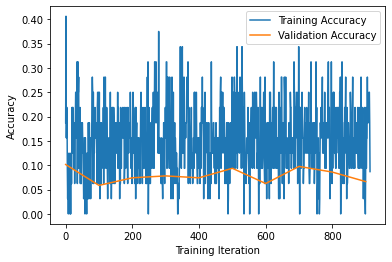

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [ ]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [ ]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()